# Get Data

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import zipfile
from datetime import datetime
from glob import glob
from joblib import Parallel, delayed
from multiprocessing import cpu_count

import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
%aimport src.data_prep_helpers
from src.data_prep_helpers import add_corona_dates

%aimport src.feature_helpers
from src.feature_helpers import calculate_daylight, get_too_hot_cold

%aimport src.ts_helpers
from src.ts_helpers import check_stationarity

%aimport src.utils
from src.utils import show_df, show_df_dtypes_nans

%aimport src.visualization_helpers
import src.visualization_helpers as vh

%aimport src.weather_helpers
from src.weather_helpers import (
    get_airport_weather_station_metadata,
    get_weather_by_station,
)

<a id="table-of-contents"></a>

## [Table of Contents](#table-of-contents)

0.  [About](#about)
1.  [User Inputs](#user-inputs)
2.  [Load Raw Data](#load-raw-data)
3.  [Raw Data Processing](#raw-data-processing)
4. [Exploratory TimeSeries Analysis of Electricity Usage by Country](#exploratory-timeseries-analysis-of-electricity-usage-by-country)
5. [Get Hourly Weather Data per Country](#get-hourly-weather-data-per-country)
6. [Exploratory TimeSeries Data Analysis of Weather by Country](#exploratory-timeseries-data-analysis-of-weather-by-country)
7. [Demographics Data by Country](#demographics-data-by-country)
8. [Combine Data Sources](#combine-data-sources)
9. [Feature Engineering](#feature-engineering)
   - 9.1. [Temperature](#temperature)
   - 9.2. [COVID-19 shock](#covid-19-shock)
10. [Export training (merged) and testing data](#export-training-(merged)-and-testing-data)
11. [Links](#links)

<a id="about"></a>

## 0. [About](#about)

Load the raw data from the OPSD open data portal, filter to select required columns and years, process (as required) and export to file for later use

<a id="user-inputs"></a>

## 1. [User Inputs](#user-inputs)

In [4]:
PROJ_ROOT_DIR = os.path.abspath(os.getcwd())

In [5]:
# General inputs
opsd_data_url = (
    "https://data.open-power-system-data.org/time_series/latest/"
    "time_series_60min_singleindex.csv"
)

load_col_name_str = "load_actual_entsoe_transparency"

# Date range
start_date = "2015"
end_date = "2020"

sstr = [
    "BE",
    "CH",  # SUI
    "CZ",
    "DE",
    "FR",
    "ES",
    "HR",
    "IT",
    "NL",
    "PL",
    "AT",
    "DK",
    "SK",
    "GB_GBN",
    "RO",
]

get_weather = True
use_demographics = False
comfort_threshold = 20

indicators_wanted = [
    "Labor force, total",
    "Population, total",
    "Trademark applications, total",
    "Listed domestic companies, total",
]
cntry_renaming_dict = {
    "country": {
        "BEL": "BE",
        "HRV": "HR",
        "CZE": "CZ",
        "FRA": "FR",
        "DEU": "DE",
        "ITA": "IT",
        "NLD": "NL",
        "POL": "PL",
        "ESP": "ES",
        "CHE": "CH",
    }
}

In [6]:
data_dir = os.path.join(PROJ_ROOT_DIR, "data")
raw_data_dir = os.path.join(data_dir, "raw")
processed_data_dir = os.path.join(data_dir, "processed")
weather_data_dir = os.path.join(raw_data_dir, "weather")

opsd_fname = os.path.basename(opsd_data_url)
opsd_fname, file_ext = os.path.splitext(opsd_fname)
print(opsd_fname)

# Weather retrieval
station_lookup_ref_point_by_country = {
    "DE": [50.1109, 8.6821, "Frankfurt Airport"],
    "BE": [50.8503, 4.3517, "Bruxelles National"],
    "HR": [45.8150, 15.9819, "Zagreb / Pleso"],
    "IT": [41.9028, 12.4964, "Roma Fiumicino"],
    "ES": [40.4168, 3.7038, "Madrid / Barajas"],
    "NL": [51.9244, 4.4777, "Rotterdam Airport Zestienhoven"],
    "PL": [52.2297, 21.0122, "Okecie"],
    "CZ": [50.0755, 14.4378, "Ruzyne"],
    "CH": [46.9480, 7.4474, "Bern / Bern - Belp Airport"],
    "FR": [48.8566, 2.3522, "Paris-Aeroport"],
}
station_cols_wanted = [
    "latitude",
    "longitude",
    "country",
    "name",
    "timezone",
    "hourly_start",
    "hourly_end",
    "distance",
]
weather_retrieval_keys = [
    "startdatehour",
    "enddatehour",
    "latitude",
    "longitude",
    "from_station_name",
    "country",
    "timezone",
]

# Stationarity
adf_rows = ["ADF_Statistic", "p-value", "likely stationary"]

start_datetime_wanted = datetime(2015, 1, 1)

time_series_60min_singleindex


In [7]:
def get_number_of_daylight_hours(df):
    daylight = calculate_daylight(df["weekday_int"], df["latitude"])
    df["daylight"] = daylight
    return df


def get_indicator_data(country):
    return pd.read_excel(
        f"https://api.worldbank.org/v2/en/country/{country}?downloadformat=excel",
        skiprows=3,
    )


def calc_cov(df, cols):
    return df[cols].std() / df[cols].mean()

<a id="load-raw-data"></a>

## 2. [Load Raw Data](#load-raw-data)

Specify column names to be loaded

In [8]:
raw_mask = [
    c + f"_{load_col_name_str}" for c in list(sstr + ["AT", "DK", "SK", "GB_GBN", "RO"])
] + ["utc_timestamp"]

Load raw data, set index, select required years and rename country names as appropriate

In [9]:
%%time
df = (
    pd.read_csv(
        opsd_data_url,
        usecols=raw_mask,
        parse_dates=["utc_timestamp"],
        index_col="utc_timestamp",
    )
    .loc[slice(str(start_date), str(end_date))]
    .rename(
        columns={
            f"CH_{load_col_name_str}": f"SUI_{load_col_name_str}"
        }
    )
)
show_df(df, 2)

,AT_load_actual_entsoe_transparency,BE_load_actual_entsoe_transparency,SUI_load_actual_entsoe_transparency,CZ_load_actual_entsoe_transparency,DE_load_actual_entsoe_transparency,DK_load_actual_entsoe_transparency,ES_load_actual_entsoe_transparency,FR_load_actual_entsoe_transparency,GB_GBN_load_actual_entsoe_transparency,HR_load_actual_entsoe_transparency,IT_load_actual_entsoe_transparency,NL_load_actual_entsoe_transparency,PL_load_actual_entsoe_transparency,RO_load_actual_entsoe_transparency,SK_load_actual_entsoe_transparency
utc_timestamp,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,5946.000000,9484.000000,nan,nan,41151.000000,nan,nan,nan,26758.000000,nan,nan,9401.000000,nan,nan,nan
2015-01-01 01:00:00+00:00,5726.000000,9152.000000,7640.140000,5957.570000,40135.000000,3100.020000,22734.000000,69773.000000,27166.000000,1812.000000,21534.000000,8957.000000,13979.460000,nan,2728.000000
2020-09-30 22:00:00+00:00,5628.000000,8131.000000,6381.760000,6416.420000,46886.000000,2926.360000,24926.000000,44869.000000,24604.000000,1483.000000,26269.000000,12519.000000,16640.110000,5540.000000,2823.000000
2020-09-30 23:00:00+00:00,5395.000000,7837.000000,nan,nan,45461.000000,nan,nan,nan,21528.000000,nan,nan,12075.000000,nan,nan,nan


CPU times: user 1.11 s, sys: 700 ms, total: 1.81 s
Wall time: 17.2 s


In [10]:
df = df.loc[:"2020-09-30 23:00:00"]
show_df(df, 2)

,AT_load_actual_entsoe_transparency,BE_load_actual_entsoe_transparency,SUI_load_actual_entsoe_transparency,CZ_load_actual_entsoe_transparency,DE_load_actual_entsoe_transparency,DK_load_actual_entsoe_transparency,ES_load_actual_entsoe_transparency,FR_load_actual_entsoe_transparency,GB_GBN_load_actual_entsoe_transparency,HR_load_actual_entsoe_transparency,IT_load_actual_entsoe_transparency,NL_load_actual_entsoe_transparency,PL_load_actual_entsoe_transparency,RO_load_actual_entsoe_transparency,SK_load_actual_entsoe_transparency
utc_timestamp,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,5946.000000,9484.000000,nan,nan,41151.000000,nan,nan,nan,26758.000000,nan,nan,9401.000000,nan,nan,nan
2015-01-01 01:00:00+00:00,5726.000000,9152.000000,7640.140000,5957.570000,40135.000000,3100.020000,22734.000000,69773.000000,27166.000000,1812.000000,21534.000000,8957.000000,13979.460000,nan,2728.000000
2020-09-30 22:00:00+00:00,5628.000000,8131.000000,6381.760000,6416.420000,46886.000000,2926.360000,24926.000000,44869.000000,24604.000000,1483.000000,26269.000000,12519.000000,16640.110000,5540.000000,2823.000000
2020-09-30 23:00:00+00:00,5395.000000,7837.000000,nan,nan,45461.000000,nan,nan,nan,21528.000000,nan,nan,12075.000000,nan,nan,nan


<a id="raw-data-processing"></a>

## 3. [Raw Data Processing](#raw-data-processing)

Change units of electricity usage

In [11]:
df = df.sort_index(ascending=True)
df /= 1000
display(df.head().append(df.tail()))

,AT_load_actual_entsoe_transparency,BE_load_actual_entsoe_transparency,SUI_load_actual_entsoe_transparency,CZ_load_actual_entsoe_transparency,DE_load_actual_entsoe_transparency,DK_load_actual_entsoe_transparency,ES_load_actual_entsoe_transparency,FR_load_actual_entsoe_transparency,GB_GBN_load_actual_entsoe_transparency,HR_load_actual_entsoe_transparency,IT_load_actual_entsoe_transparency,NL_load_actual_entsoe_transparency,PL_load_actual_entsoe_transparency,RO_load_actual_entsoe_transparency,SK_load_actual_entsoe_transparency
utc_timestamp,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,5.946,9.484,NaN,NaN,41.151,NaN,NaN,NaN,26.758,NaN,NaN,9.401,NaN,NaN,NaN
2015-01-01 01:00:00+00:00,5.726,9.152,7.64014,5.95757,40.135,3.10002,22.734,69.773,27.166,1.812,21.534,8.957,13.97946,NaN,2.728
2015-01-01 02:00:00+00:00,5.347,8.799,7.39144,5.87887,39.106,2.98039,21.286,66.417,24.472,1.712,20.219,8.462,13.45378,NaN,2.626
2015-01-01 03:00:00+00:00,5.249,8.567,7.33257,5.82780,38.765,2.93349,20.264,64.182,23.003,1.646,19.470,8.156,13.30600,NaN,2.618
2015-01-01 04:00:00+00:00,5.309,8.487,7.00208,5.73089,38.941,2.94154,19.905,63.859,21.832,1.657,19.485,8.126,13.17558,NaN,2.626
2020-09-30 19:00:00+00:00,6.661,9.402,6.33481,7.60502,57.559,4.05722,30.860,48.210,37.522,2.047,35.217,14.522,20.78889,6.591,3.324
2020-09-30 20:00:00+00:00,6.336,9.219,6.51008,7.17336,54.108,3.52375,27.994,48.210,33.898,1.909,31.537,13.810,19.04056,6.061,3.099
2020-09-30 21:00:00+00:00,5.932,8.763,6.81227,6.76314,49.845,3.11495,25.706,48.058,29.748,1.684,28.730,13.118,17.69731,5.738,2.940
2020-09-30 22:00:00+00:00,5.628,8.131,6.38176,6.41642,46.886,2.92636,24.926,44.869,24.604,1.483,26.269,12.519,16.64011,5.540,2.823


Verify that the full range of date-times is present in the provided data
- this does not mean that the electricity load for all these timestamps is present (from a quick visual inspection of the data shown immediately above, we can already tell that we have some missing data), but that the associated range of timestamps, at which the load is provided, matches what we expect it to be

In [12]:
assert len(df) == len(
    pd.date_range(datetime(2015, 1, 1), df.index.tz_localize(None).max(), freq="H")
)

Reshape the electricity consumption data into the [tidy data format](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html) and filter the data to select the subset of countries for which quantitative analysis will be performed

In [13]:
%%time
df = df.unstack().reset_index().rename(columns={0: "load"})
df["country"] = df["level_0"].str[:2]
df["country"] = df["country"].str.replace("SU", "CH")
df = df[["country", "utc_timestamp", "load"]]
df = df[df["country"].isin(list(station_lookup_ref_point_by_country))]
display(df.head().append(df.tail()))
display(df.isna().sum().to_frame())
display(df.dtypes.to_frame())

,country,utc_timestamp,load
50400,BE,2015-01-01 00:00:00+00:00,9.48400
50401,BE,2015-01-01 01:00:00+00:00,9.15200
50402,BE,2015-01-01 02:00:00+00:00,8.79900
50403,BE,2015-01-01 03:00:00+00:00,8.56700
50404,BE,2015-01-01 04:00:00+00:00,8.48700
655195,PL,2020-09-30 19:00:00+00:00,20.78889
655196,PL,2020-09-30 20:00:00+00:00,19.04056
655197,PL,2020-09-30 21:00:00+00:00,17.69731
655198,PL,2020-09-30 22:00:00+00:00,16.64011
655199,PL,2020-09-30 23:00:00+00:00,NaN


,0
country,0
utc_timestamp,0
load,182


,0
country,object
utc_timestamp,"datetime64[ns, UTC]"
load,float64


CPU times: user 526 ms, sys: 3.3 ms, total: 529 ms
Wall time: 528 ms


Add temporal features to reshaped and filtered electricity load data

In [14]:
df["month"] = df["utc_timestamp"].dt.month_name()
df["weekday"] = df["utc_timestamp"].dt.day_name()
df["weekday_int"] = df["utc_timestamp"].dt.weekday
df["is_weekend"] = df["weekday_int"].isin([5, 6])
df["hour"] = df["utc_timestamp"].dt.hour
df["year"] = df["utc_timestamp"].dt.year

Remove the timezone from the timestamp column

In [15]:
df["utc_timestamp"] = df["utc_timestamp"].dt.tz_localize(None)

<a id="exploratory-timeseries-analysis-of-electricity-usage-by-country"></a>

## 4. [Exploratory TimeSeries Analysis of Electricity Usage by Country](#exploratory-timeseries-analysis-of-electricity-usage-by-country)

Plot the timeseries for the electricity consumption in `FR`

CPU times: user 274 ms, sys: 8.58 ms, total: 283 ms
Wall time: 282 ms


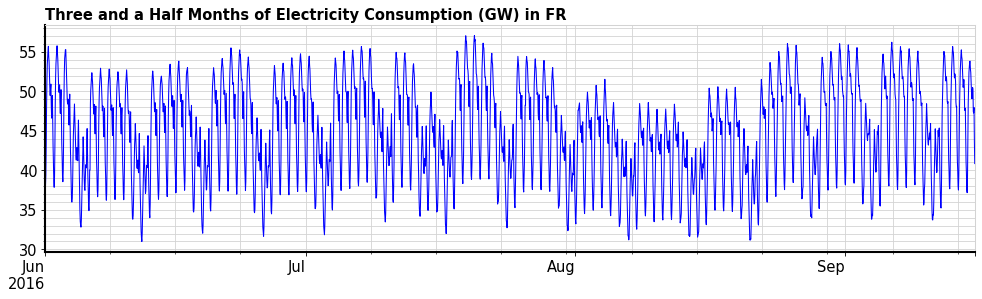

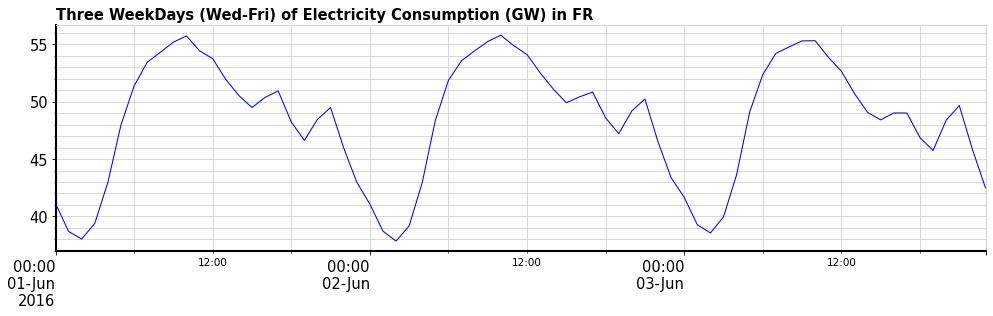

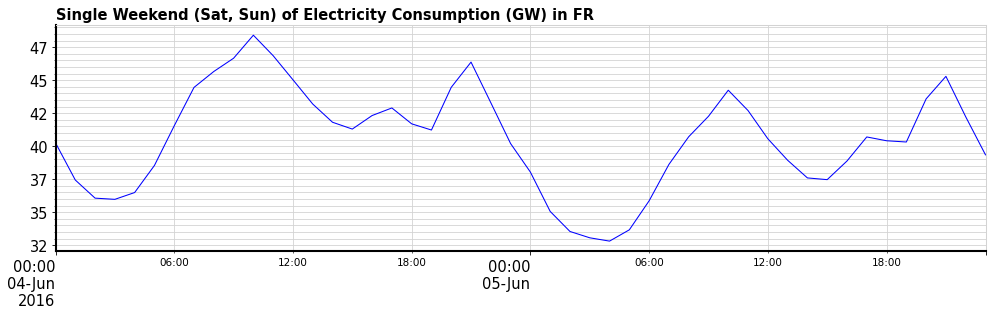

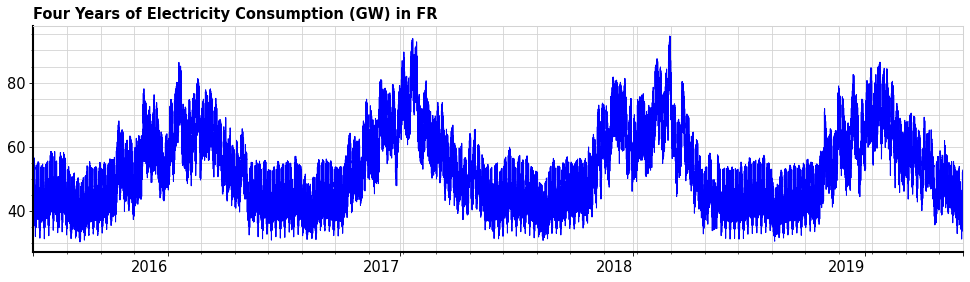

In [16]:
%%time
country = "FR"
ts = df[df["country"] == country].set_index("utc_timestamp")["load"]
plot_dict = {country: [ts.loc["2016-06-01":"2016-09-15"], "blue", "-", 1]}
vh.plot_multi_ts(
    plot_dict,
    f"Three and a Half Months of Electricity Consumption (GW) in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=12,
    dpi=75,
    xtick_halign="right",
    xtick_angle=0,
    fig_size=(16, 4),
)

plot_dict = {country: [ts.loc["2016-06-01":"2016-06-03"], "blue", "-", 1]}
vh.plot_multi_ts(
    plot_dict,
    f"Three WeekDays (Wed-Fri) of Electricity Consumption (GW) in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=12,
    dpi=75,
    xtick_halign="right",
    xtick_angle=0,
    fig_size=(16, 4),
)

plot_dict = {country: [ts.loc["2016-06-04":"2016-06-05"], "blue", "-", 1]}
vh.plot_multi_ts(
    plot_dict,
    f"Single Weekend (Sat, Sun) of Electricity Consumption (GW) in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=12,
    dpi=75,
    xtick_halign="right",
    xtick_angle=0,
    fig_size=(16, 4),
)

plot_dict = {country: [ts.loc["2015-06-04":"2019-06-04"], "blue", "-", 1]}
vh.plot_multi_ts(
    plot_dict,
    f"Four Years of Electricity Consumption (GW) in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=12,
    dpi=75,
    xtick_halign="right",
    xtick_angle=0,
    fig_size=(16, 4),
)

**Observations**
1. The electricity usage demonstrates a strong daily seasonality. On a yearly basis, we see the same general shape from year to year suggesting a reasonably predictable yearly seasonality.
2. From comparing the load across years, there is no evidence of a trend in the timeseries.

Check stationarity ([1](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc442.htm), [2](https://otexts.com/fpp2/stationarity.html#stationarity)) of this electricity usage timeseries using a statistical test ([Augmented Dickey Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test))

In [17]:
%%time
check_stationarity(ts, f"load-{country}").style.apply(
    lambda x: ['background-color: yellow' if x.name in adf_rows else '' for i in x],
    axis=1
)

CPU times: user 27.2 s, sys: 39.9 s, total: 1min 7s
Wall time: 5.97 s


,Value,module
name,load-FR,nan
ADF_Statistic,-7.832828,adfuller
p-value,0.000000,adfuller
num_lags_used,57,adfuller
n_observations_used,50299,adfuller
IC_for_best,155580.306284,adfuller
1%,-3.430480,adfuller
5%,-2.861597,adfuller
10%,-2.566801,adfuller
likely stationary,True,p-value < 0.05


**Observations**
1. The ADF test suggests that the electricity consumption timeseries data is stationary. However, as we can clearly see, daily seasonality is clearly present in the data and is periodic with predictable timing of peaks and troughs. So, the timeseries for electricity use in `FR` is not stationary.

Plot a histogram of the electricity usage timeseries data in `FR`

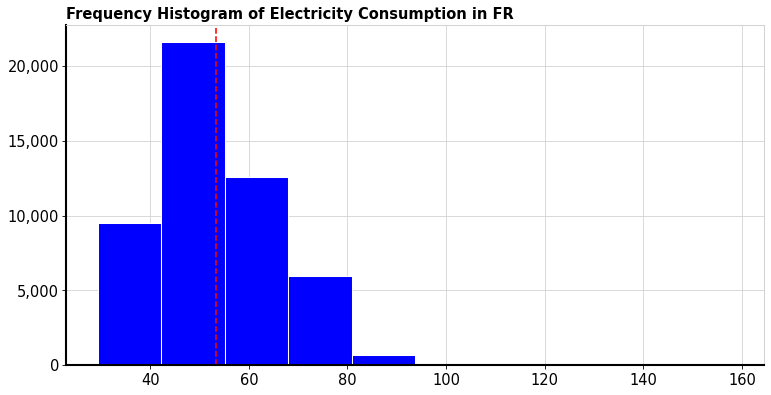

In [18]:
vh.plot_histogram(
    ts,
    f"Frequency Histogram of Electricity Consumption in {country}",
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    dpi=75,
    x_thou_comma_sep=False,
    y_thou_comma_sep=True,
    fig_size=(12, 6),
)

**Observations**
1. The distribution is right-skewed.

Plot the auto-correlation of the electricity consumption timeseries in `FR`

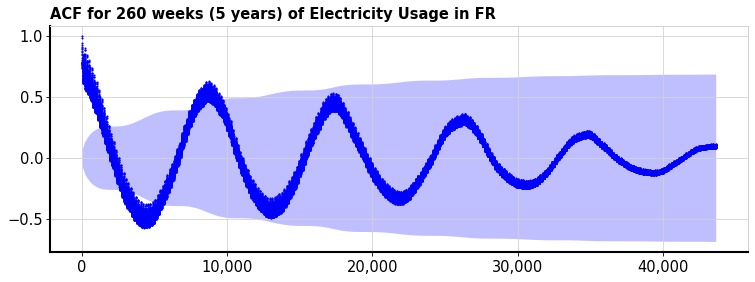

In [19]:
vh.plot_ts_acf(
    ts.dropna(),
    f"ACF for {52*5} weeks ({5} years) of Electricity Usage in {country}",
    24 * 7 * 52 * 5,
    1,
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    dpi=75,
    fig_size=(12, 4),
)

**Observations**
1. There is predictably a strong autocorrelation in the electricity consumption in a single country.

View a transformed timeseries and associated histogram for electricity use in `FR`
- the transformation applied is the yearly differencing ([1](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average#Differencing), [2](https://www.statistics.com/glossary/differencing-of-time-series/)) of the raw hourly data (subtract electricity usage from 52 weeks, or 24 X 7 X 52 = 8,736 hours, ago from the current hourly usage) for the electricity load in `FR`

CPU times: user 174 ms, sys: 26.2 ms, total: 200 ms
Wall time: 174 ms


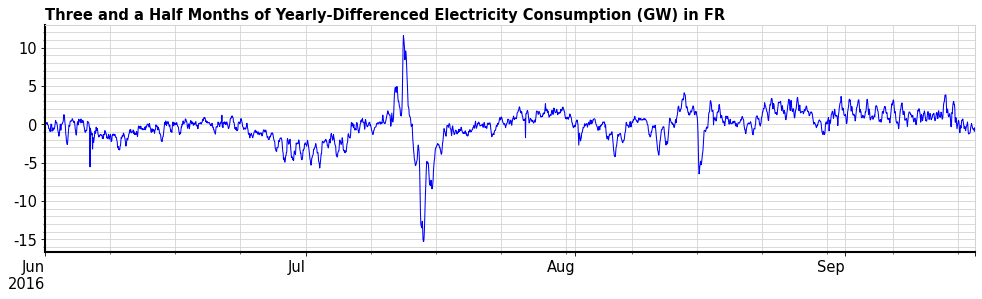

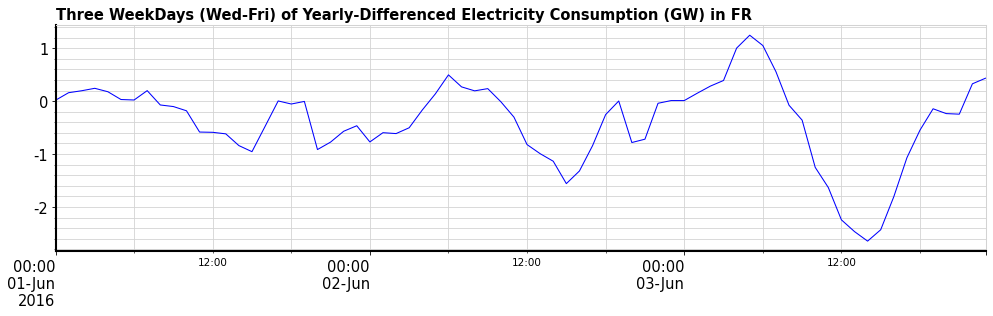

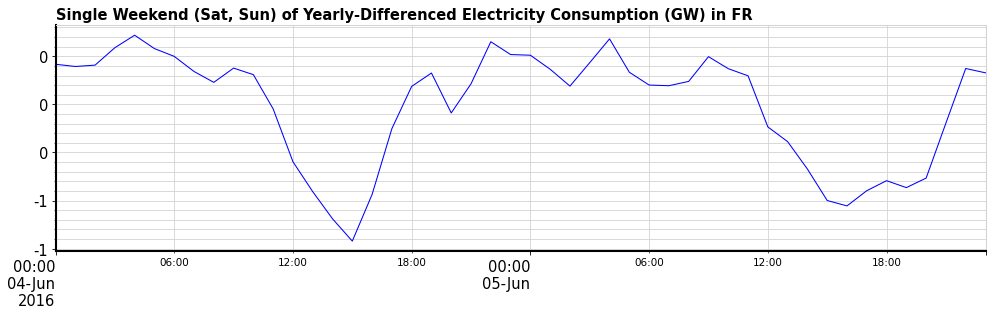

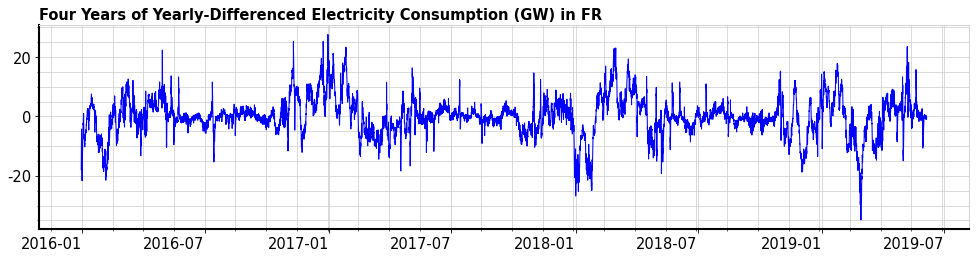

In [20]:
%%time
ts = ts.diff(24*7*52).dropna()
plot_dict = {country: [ts.loc["2016-06-01":"2016-09-15"], "blue", "-", 1]}
vh.plot_multi_ts(
    plot_dict,
    f"Three and a Half Months of Yearly-Differenced Electricity Consumption (GW) in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=12,
    dpi=75,
    xtick_halign="right",
    xtick_angle=0,
    fig_size=(16, 4),
)

plot_dict = {country: [ts.loc["2016-06-01":"2016-06-03"], "blue", "-", 1]}
vh.plot_multi_ts(
    plot_dict,
    f"Three WeekDays (Wed-Fri) of Yearly-Differenced Electricity Consumption (GW) in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=12,
    dpi=75,
    xtick_halign="right",
    xtick_angle=0,
    fig_size=(16, 4),
)

plot_dict = {country: [ts.loc["2016-06-04":"2016-06-05"], "blue", "-", 1]}
vh.plot_multi_ts(
    plot_dict,
    f"Single Weekend (Sat, Sun) of Yearly-Differenced Electricity Consumption (GW) in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=12,
    dpi=75,
    xtick_halign="right",
    xtick_angle=0,
    fig_size=(16, 4),
)

plot_dict = {country: [ts.loc["2015-06-04":"2019-06-04"], "blue", "-", 1]}
vh.plot_multi_ts(
    plot_dict,
    f"Four Years of Yearly-Differenced Electricity Consumption (GW) in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=12,
    dpi=75,
    xtick_halign="right",
    xtick_angle=0,
    fig_size=(16, 4),
)

Check stationarity of the transformed timeseries for `FR`

In [21]:
%%time
check_stationarity(ts, f"{country}-transformed").style.apply(
    lambda x: ['background-color: yellow' if x.name in adf_rows else '' for i in x],
    axis=1
)

CPU times: user 18.4 s, sys: 31.7 s, total: 50 s
Wall time: 4.6 s


,Value,module
name,FR-transformed,nan
ADF_Statistic,-10.891581,adfuller
p-value,0.000000,adfuller
num_lags_used,51,adfuller
n_observations_used,41540,adfuller
IC_for_best,111952.419439,adfuller
1%,-3.430507,adfuller
5%,-2.861610,adfuller
10%,-2.566807,adfuller
likely stationary,True,p-value < 0.05


**Observations**
1. The ADF test suggests that the transformed timeseries data is stationary. There doesn't appear to be visual evidence of the intra-day pattern of usage (peak usage during the morning and night) after applying this yearly differencing transformation. Also, there aren't strong cycles that we can visually identify after the transformation. So, the transformed load timeseries in `FR` is stationary.

Plot a histogram of the transformed electricity usage timeseries data

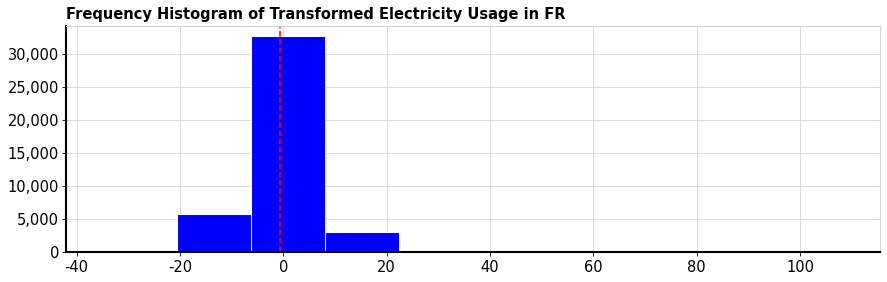

In [22]:
vh.plot_histogram(
    ts,
    f"Frequency Histogram of Transformed Electricity Usage in {country}",
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    dpi=75,
    x_thou_comma_sep=True,
    y_thou_comma_sep=True,
    fig_size=(14, 4),
)

**Observations**
1. This transformed electricity consumption timeseries in `FR` appears to follow a Poisson distribution, with a weak right skew likely due to the presence of outliers which correspond to slightly off-cycle usage that could not be removed by the differencing.

Plot the auto-correlation of this transformed electricity usage timeseries

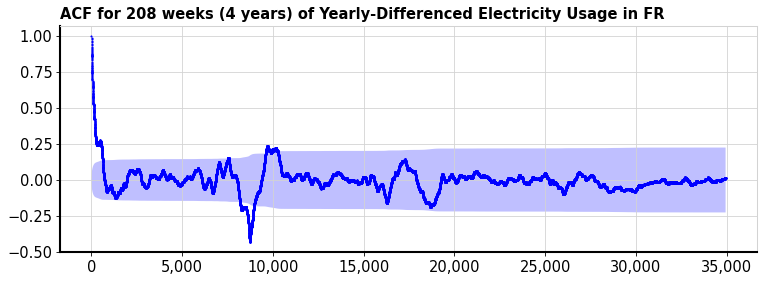

In [23]:
vh.plot_ts_acf(
    ts.dropna(),
    f"ACF for {52*4} weeks ({4} years) of Yearly-Differenced Electricity Usage in {country}",
    24 * 7 * 52 * 4,
    1,
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    dpi=75,
    fig_size=(12, 4),
)

**Observations**
1. As a rough estimate, with the exception of a single period after approx. 8,000 hours (a little less than one year's worth or hourly data points of electricity usage), autocorrelation beyond approx. 1,000 hours (approx. 140 days, or 5 months) is usually very small.

Plot the timeseries for the electricity consumption in `ES`

CPU times: user 181 ms, sys: 0 ns, total: 181 ms
Wall time: 181 ms


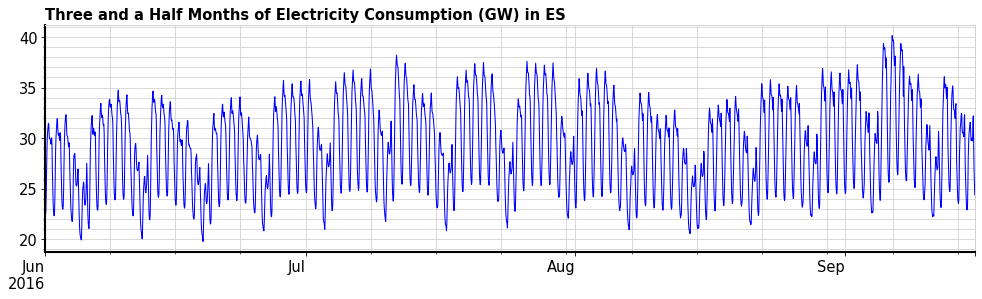

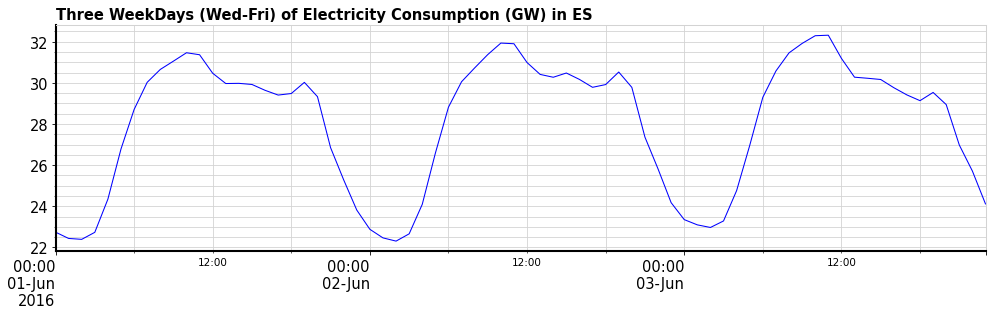

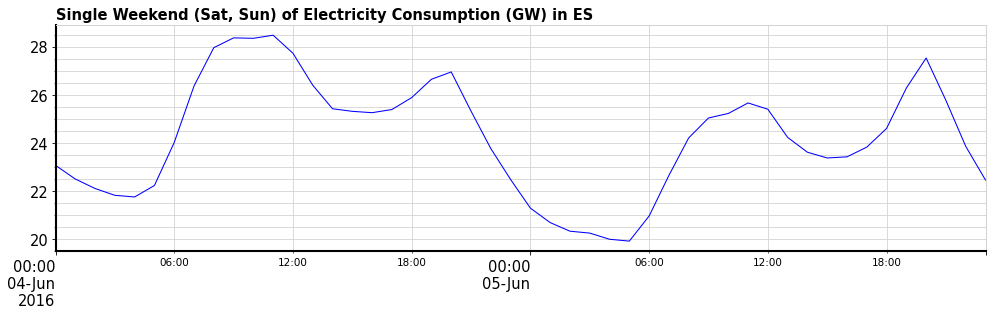

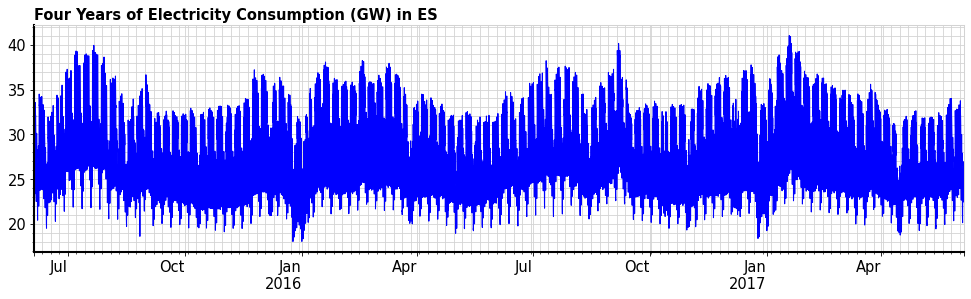

In [24]:
%%time
country = "ES"
ts = df[df["country"] == country].set_index("utc_timestamp")["load"]
plot_dict = {country: [ts.loc["2016-06-01":"2016-09-15"], "blue", "-", 1]}
vh.plot_multi_ts(
    plot_dict,
    f"Three and a Half Months of Electricity Consumption (GW) in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=12,
    dpi=75,
    xtick_halign="right",
    xtick_angle=0,
    fig_size=(16, 4),
)

plot_dict = {country: [ts.loc["2016-06-01":"2016-06-03"], "blue", "-", 1]}
vh.plot_multi_ts(
    plot_dict,
    f"Three WeekDays (Wed-Fri) of Electricity Consumption (GW) in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=12,
    dpi=75,
    xtick_halign="right",
    xtick_angle=0,
    fig_size=(16, 4),
)

plot_dict = {country: [ts.loc["2016-06-04":"2016-06-05"], "blue", "-", 1]}
vh.plot_multi_ts(
    plot_dict,
    f"Single Weekend (Sat, Sun) of Electricity Consumption (GW) in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=12,
    dpi=75,
    xtick_halign="right",
    xtick_angle=0,
    fig_size=(16, 4),
)

plot_dict = {country: [ts.loc["2015-06-04":"2017-06-04"], "blue", "-", 1]}
vh.plot_multi_ts(
    plot_dict,
    f"Four Years of Electricity Consumption (GW) in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=12,
    dpi=75,
    xtick_halign="right",
    xtick_angle=0,
    fig_size=(16, 4),
)

**Observations**
1. As before, the electricity usage in `ES` demonstrates a strong daily seasonality with peak usage during the morning and late-evening hours. The daily seasonality is smoother than the usage pattern in `FR`. On a yearly basis, we again see the same general shape from year to year - a predictable yearly seasonality.
2. There is no evidence of a trend in the electricity usage in `ES`.

Check stationarity of this electricity usage timeseries using the ADF test

In [25]:
%%time
check_stationarity(ts, country).style.apply(
    lambda x: ['background-color: yellow' if x.name in adf_rows else '' for i in x],
    axis=1
)

CPU times: user 22.5 s, sys: 33.6 s, total: 56.1 s
Wall time: 4.81 s


,Value,module
name,ES,nan
ADF_Statistic,-17.614571,adfuller
p-value,0.000000,adfuller
num_lags_used,57,adfuller
n_observations_used,50320,adfuller
IC_for_best,61515.885294,adfuller
1%,-3.430480,adfuller
5%,-2.861597,adfuller
10%,-2.566801,adfuller
likely stationary,True,p-value < 0.05


**Observations**
1. As before, the ADF test suggests that the electricity consumption timeseries data is stationary. But, as before, intra-day seasonality is present and is predictable. The timeseries for electricity use in `ES` is not stationary.

Plot a histogram of the electricity usage timeseries data in `ES`

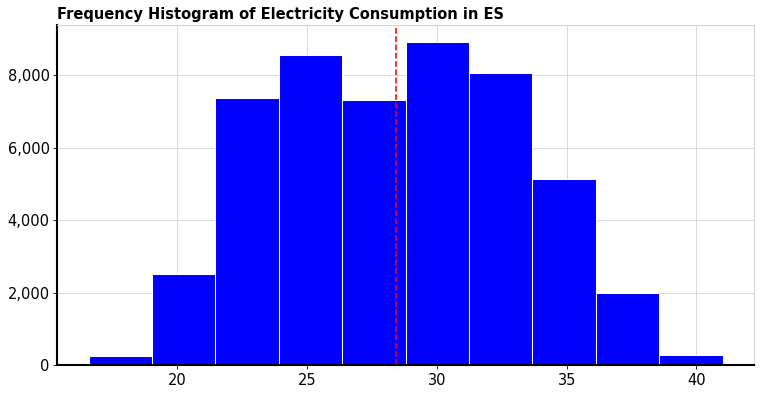

In [26]:
vh.plot_histogram(
    ts,
    f"Frequency Histogram of Electricity Consumption in {country}",
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    dpi=75,
    x_thou_comma_sep=False,
    y_thou_comma_sep=True,
    fig_size=(12, 6),
)

**Observations**
1. As before, the distribution appears to be bi-modal, with the modes centered around the average electricity use during the evening/overnight hours of each day (approx. 25 GW) and early-mid day consumption period (approx. 30 GW).

Plot the auto-correlation of the electricity consumption timeseries in `ES`

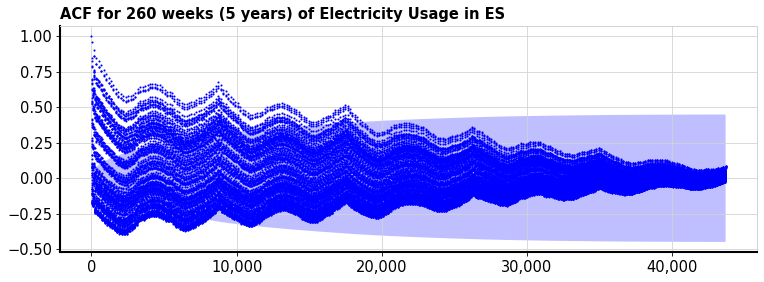

In [27]:
vh.plot_ts_acf(
    ts.dropna(),
    f"ACF for {52*5} weeks ({5} years) of Electricity Usage in {country}",
    24 * 7 * 52 * 5,
    1,
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    dpi=75,
    fig_size=(12, 4),
)

**Observations**
1. As with consumption in `FR`, there is strong autocorrelation.

View transformed timeseries and associated histogram for electricity use in `ES`

CPU times: user 189 ms, sys: 1.76 ms, total: 191 ms
Wall time: 189 ms


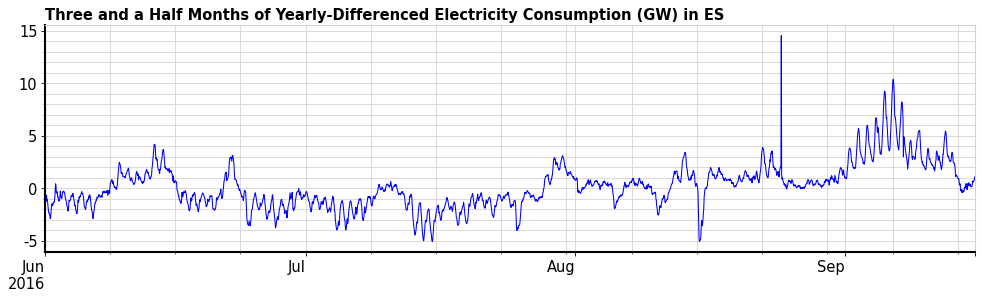

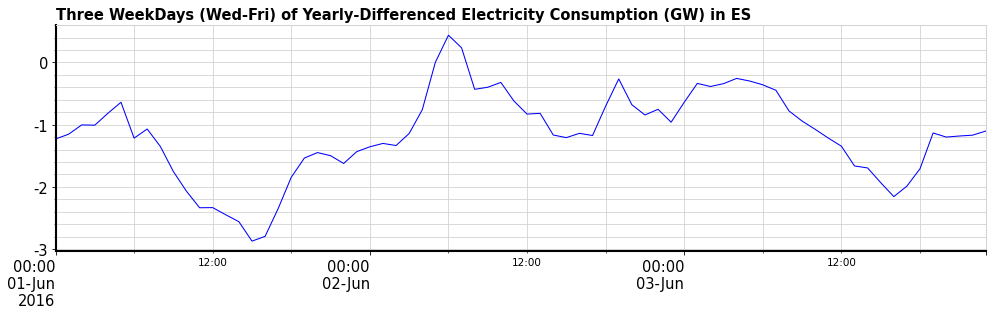

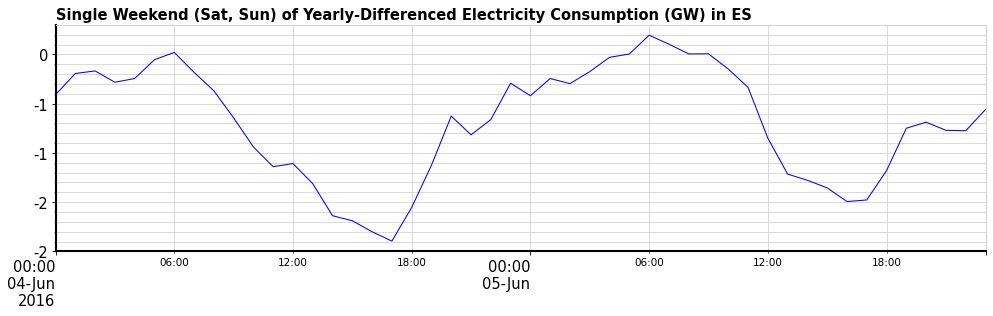

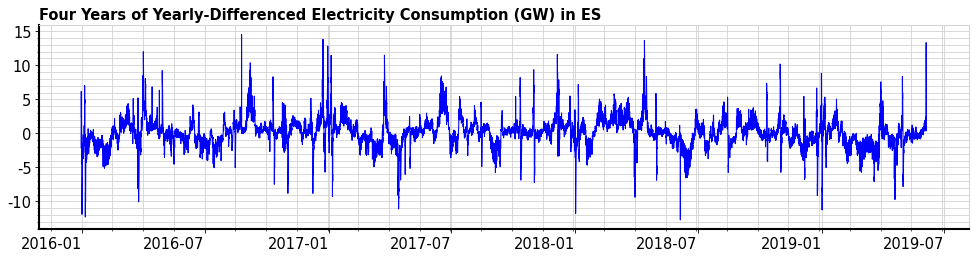

In [28]:
%%time
ts = ts.diff(24*7*52).dropna()
plot_dict = {country: [ts.loc["2016-06-01":"2016-09-15"], "blue", "-", 1]}
vh.plot_multi_ts(
    plot_dict,
    f"Three and a Half Months of Yearly-Differenced Electricity Consumption (GW) in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=12,
    dpi=75,
    xtick_halign="right",
    xtick_angle=0,
    fig_size=(16, 4),
)

plot_dict = {country: [ts.loc["2016-06-01":"2016-06-03"], "blue", "-", 1]}
vh.plot_multi_ts(
    plot_dict,
    f"Three WeekDays (Wed-Fri) of Yearly-Differenced Electricity Consumption (GW) in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=12,
    dpi=75,
    xtick_halign="right",
    xtick_angle=0,
    fig_size=(16, 4),
)

plot_dict = {country: [ts.loc["2016-06-04":"2016-06-05"], "blue", "-", 1]}
vh.plot_multi_ts(
    plot_dict,
    f"Single Weekend (Sat, Sun) of Yearly-Differenced Electricity Consumption (GW) in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=12,
    dpi=75,
    xtick_halign="right",
    xtick_angle=0,
    fig_size=(16, 4),
)

plot_dict = {country: [ts.loc["2015-06-04":"2019-06-04"], "blue", "-", 1]}
vh.plot_multi_ts(
    plot_dict,
    f"Four Years of Yearly-Differenced Electricity Consumption (GW) in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=12,
    dpi=75,
    xtick_halign="right",
    xtick_angle=0,
    fig_size=(16, 4),
)

The seasonal decomposition (to separate the underlying seasonality and trend in the transformed data) of this differenced timeseries in `ES` is shown below

CPU times: user 56.9 ms, sys: 1.42 ms, total: 58.4 ms
Wall time: 54.7 ms


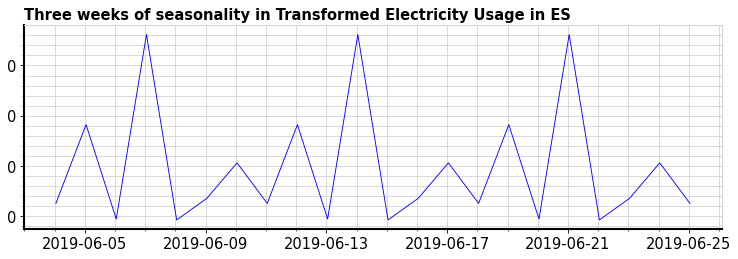

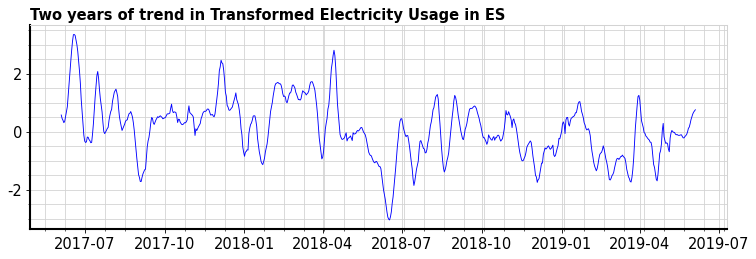

In [29]:
%%time
result = seasonal_decompose(ts.asfreq(None), model="additive")
plot_dict = {"wspd": [result.seasonal.loc["2019-06-04":"2019-06-25"], "blue", "-", 0.85]}
vh.plot_multi_ts(
    plot_dict,
    f"Three weeks of seasonality in Transformed Electricity Usage in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=14,
    dpi=75,
    fig_size=(12, 4),
)
plot_dict = {"wspd": [result.trend.loc["2017-06-04":"2019-06-04"], "blue", "-", 0.85]}
vh.plot_multi_ts(
    plot_dict,
    f"Two years of trend in Transformed Electricity Usage in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=14,
    dpi=75,
    fig_size=(12, 4),
)

**Observations**
1. The yearly differencing transformation is less convincing in `ES` than in `FR`. There does appear to be visual evidence of a daily pattern of usage (especially on the weekends) after applying this yearly differencing transformation. It might be that the weekly period (assumed here to be 7 days) needs to be slightly adjusted and be considered as a float (eg. fraction of a week such as 6.8, 6.95, etc.) rather than an integer. In addition a seasonal pattern can be obtained from the seasonal decomposition. So, the transformed load timeseries in `ES` does not appear to be stationary.

**Conclusions**
1. As we move to lower levels of detail in our analysis, patterns more easily modeled at higher levels of granularity may no longer be reliably present, making the generation of forecasts with techniques applicable at higher levels more challenging.
2. As we move closer to the transaction level of granularity, we also need to consider the external causal factors that influence individual customer demand and purchase decisions. In aggregate, these may be reflected in the averages, trends and seasonality that make up a time series but at finer levels of granularity, we may need to incorporate these directly into our forecasting models.
3. Moving to a finer level of granularity increases the likelihood the structure of our data will not allow for the use of traditional forecasting techniques. The closer we move to the transaction grain, the higher the likelihood we will need to address periods of inactivity in our data. At this level of granularity, our dependent variables, especially when dealing with count data such as units sold, may take on a skewed distribution that’s not amenable to simple transformations and which may require the use of forecasting techniques outside the comfort zone of many Data Scientists.

<a id="get-hourly-weather-data-per-country"></a>

## 5. [Get Hourly Weather Data per Country](#get-hourly-weather-data-per-country)

Get weather station metadata for the list of chosen countries for performing quantitative analysis
- the weather station will be one based at an airport in each country

In [30]:
%%time
df_stations = get_airport_weather_station_metadata(
    station_lookup_ref_point_by_country,
    station_cols_wanted,
)
df_stations["startdatehour"] = start_datetime_wanted
df_stations["enddatehour"] = df["utc_timestamp"].dt.tz_localize(None).max()
show_df(df_stations, 5)
show_df_dtypes_nans(df_stations)

,latitude,longitude,country,from_station_name,timezone,hourly_start,hourly_end,distance,startdatehour,enddatehour
0,50.050000,8.600000,DE,Frankfurt Airport,Europe/Berlin,1926-01-01 00:00:00,2021-09-02 00:00:00,8954.102329,2015-01-01 00:00:00,2020-09-30 23:00:00
1,50.900000,4.533300,BE,Bruxelles National,Europe/Brussels,1930-03-02 00:00:00,2021-09-02 00:00:00,13888.851017,2015-01-01 00:00:00,2020-09-30 23:00:00
2,45.733300,16.066700,HR,Zagreb_Pleso,Europe/Zagreb,1996-02-01 00:00:00,2021-09-02 00:00:00,11215.405799,2015-01-01 00:00:00,2020-09-30 23:00:00
3,41.800000,12.233300,IT,Roma Fiumicino,Europe/Rome,1965-07-01 00:00:00,2021-09-02 00:00:00,24607.739120,2015-01-01 00:00:00,2020-09-30 23:00:00
4,40.450000,-3.550000,ES,Madrid_Barajas,Europe/Madrid,1931-01-02 00:00:00,2021-09-02 00:00:00,613779.571063,2015-01-01 00:00:00,2020-09-30 23:00:00
5,51.950000,4.450000,NL,Rotterdam Airport Zestienhoven,Europe/Amsterdam,1957-01-01 00:00:00,2021-09-02 00:00:00,3421.858488,2015-01-01 00:00:00,2020-09-30 23:00:00
6,52.166700,20.966700,PL,Warszawa-Okecie,Europe/Warsaw,1928-01-02 00:00:00,2021-09-02 00:00:00,7660.969241,2015-01-01 00:00:00,2020-09-30 23:00:00
7,50.100000,14.250000,CZ,Praha_Ruzyne,Europe/Prague,1929-08-02 00:00:00,2021-09-02 00:00:00,13672.589034,2015-01-01 00:00:00,2020-09-30 23:00:00
8,46.913600,7.500300,CH,Bern_Bern - Belp Airport,Europe/Zurich,1990-04-24 00:00:00,2021-09-02 00:00:00,5546.758102,2015-01-01 00:00:00,2020-09-30 23:00:00
9,49.016700,2.533300,FR,Paris-Aeroport Charles De Gaulle,Europe/Paris,1974-04-19 00:00:00,2021-09-02 00:00:00,22178.923845,2015-01-01 00:00:00,2020-09-30 23:00:00


,num_missing,dtypes
latitude,0,float64
longitude,0,float64
country,0,string
from_station_name,0,object
timezone,0,string
hourly_start,0,datetime64[ns]
hourly_end,0,datetime64[ns]
distance,0,float64
startdatehour,0,datetime64[ns]
enddatehour,0,datetime64[ns]


CPU times: user 173 ms, sys: 4.93 ms, total: 177 ms
Wall time: 176 ms


Retrieve weather data every hour for a single airport-based weather station location (latitude and longitude) in each country, for the range of date-hour combinations that covers electricity usage in that country

In [31]:
%%time
if get_weather:
    df_weather = get_weather_by_station(
        df_stations,
        weather_retrieval_keys,
        weather_data_dir,
        location_type="from_station_name",
        time_colname="startdatehour",
    )
else:
    df_weather = pd.read_parquet(weather_data_dir, engine="auto")
show_df(df_weather, 3)
show_df_dtypes_nans(df_weather)

,startdatehour,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,from_station_name,country,year,timezone
0,2015-01-01 00:00:00,1.200000,1.200000,100.000000,0.000000,nan,200.000000,6.500000,nan,1037.400000,nan,nan,Frankfurt Airport,DE,2015,Europe/Berlin
1,2015-01-01 01:00:00,1.200000,1.200000,100.000000,0.000000,nan,190.000000,5.800000,nan,1037.300000,0.000000,nan,Frankfurt Airport,DE,2015,Europe/Berlin
2,2015-01-01 02:00:00,1.100000,1.100000,100.000000,0.000000,nan,190.000000,4.700000,nan,1037.500000,0.000000,nan,Frankfurt Airport,DE,2015,Europe/Berlin
503997,2020-09-30 21:00:00,16.400000,12.400000,77.000000,0.000000,nan,170.000000,13.000000,24.100000,1009.800000,nan,3.000000,Paris-Aeroport Charles De Gaulle,FR,2020,Europe/Paris
503998,2020-09-30 22:00:00,15.900000,12.800000,82.000000,0.000000,nan,170.000000,13.000000,24.100000,1009.200000,nan,3.000000,Paris-Aeroport Charles De Gaulle,FR,2020,Europe/Paris
503999,2020-09-30 23:00:00,15.600000,12.500000,82.000000,0.000000,nan,160.000000,14.800000,25.900000,1008.600000,nan,3.000000,Paris-Aeroport Charles De Gaulle,FR,2020,Europe/Paris


,num_missing,dtypes
startdatehour,0,datetime64[ns]
temp,0,float64
dwpt,0,float64
rhum,0,float64
prcp,153940,float64
snow,363238,float64
wdir,0,float64
wspd,0,float64
wpgt,319543,float64
pres,5890,float64


CPU times: user 263 ms, sys: 132 ms, total: 395 ms
Wall time: 4.61 s


Check that historical weather data has been retrieved for the specified range of timestamps from the electricity usage data

In [32]:
df_stations_dates = (
    df_stations.groupby("country", as_index=False)
    .agg({"startdatehour": "min", "enddatehour": "max"})
    .rename(columns={"startdatehour": "start", "enddatehour": "end"})
)

df_load_dates = (
    df[df["country"].isin(list(station_lookup_ref_point_by_country))]
    .groupby("country")
    .agg({"utc_timestamp": ["min", "max"]})
)
df_load_dates.columns = df_load_dates.columns.map("_".join)
df_load_dates = df_load_dates.reset_index().rename(
    columns={"utc_timestamp_min": "start", "utc_timestamp_max": "end"}
)

df_weather_dates = df_weather.groupby("country").agg({"startdatehour": ["min", "max"]})
df_weather_dates.columns = df_weather_dates.columns.map("_".join)
df_weather_dates = df_weather_dates.reset_index()

display(
    df_stations_dates.merge(
        df_load_dates, on=["country"], how="left", suffixes=["_stations", "_load"]
    )
    .merge(df_weather_dates, on=["country"], how="left")
    .rename(
        columns={
            "startdatehour_min": "start_weather",
            "startdatehour_max": "end_weather",
        }
    )
    .style.set_caption(
        "Comparison of start and end dates from datasets for "
        "weather stations metadata, electricity usage (load) and weather"
    )
)

assert df_stations_dates.equals(
    df_weather_dates.rename(
        columns={
            "startdatehour_min": "start",
            "startdatehour_max": "end",
        }
    )
)
assert df_load_dates.equals(
    df_weather_dates.rename(
        columns={
            "startdatehour_min": "start",
            "startdatehour_max": "end",
        }
    )
)

,country,start_stations,end_stations,start_load,end_load,start_weather,end_weather
0,BE,2015-01-01 00:00:00,2020-09-30 23:00:00,2015-01-01 00:00:00,2020-09-30 23:00:00,2015-01-01 00:00:00,2020-09-30 23:00:00
1,CH,2015-01-01 00:00:00,2020-09-30 23:00:00,2015-01-01 00:00:00,2020-09-30 23:00:00,2015-01-01 00:00:00,2020-09-30 23:00:00
2,CZ,2015-01-01 00:00:00,2020-09-30 23:00:00,2015-01-01 00:00:00,2020-09-30 23:00:00,2015-01-01 00:00:00,2020-09-30 23:00:00
3,DE,2015-01-01 00:00:00,2020-09-30 23:00:00,2015-01-01 00:00:00,2020-09-30 23:00:00,2015-01-01 00:00:00,2020-09-30 23:00:00
4,ES,2015-01-01 00:00:00,2020-09-30 23:00:00,2015-01-01 00:00:00,2020-09-30 23:00:00,2015-01-01 00:00:00,2020-09-30 23:00:00
5,FR,2015-01-01 00:00:00,2020-09-30 23:00:00,2015-01-01 00:00:00,2020-09-30 23:00:00,2015-01-01 00:00:00,2020-09-30 23:00:00
6,HR,2015-01-01 00:00:00,2020-09-30 23:00:00,2015-01-01 00:00:00,2020-09-30 23:00:00,2015-01-01 00:00:00,2020-09-30 23:00:00
7,IT,2015-01-01 00:00:00,2020-09-30 23:00:00,2015-01-01 00:00:00,2020-09-30 23:00:00,2015-01-01 00:00:00,2020-09-30 23:00:00
8,NL,2015-01-01 00:00:00,2020-09-30 23:00:00,2015-01-01 00:00:00,2020-09-30 23:00:00,2015-01-01 00:00:00,2020-09-30 23:00:00
9,PL,2015-01-01 00:00:00,2020-09-30 23:00:00,2015-01-01 00:00:00,2020-09-30 23:00:00,2015-01-01 00:00:00,2020-09-30 23:00:00


<a id="exploratory-timeseries-data-analysis-of-weather-by-country"></a>

## 6. [Exploratory TimeSeries Data Analysis of Weather by Country](#exploratory-timeseries-data-analysis-of-weather-by-country)

Plot the timeseries for the temperature column in the weather data for a single country (`DE`)

CPU times: user 306 ms, sys: 13.1 ms, total: 319 ms
Wall time: 318 ms


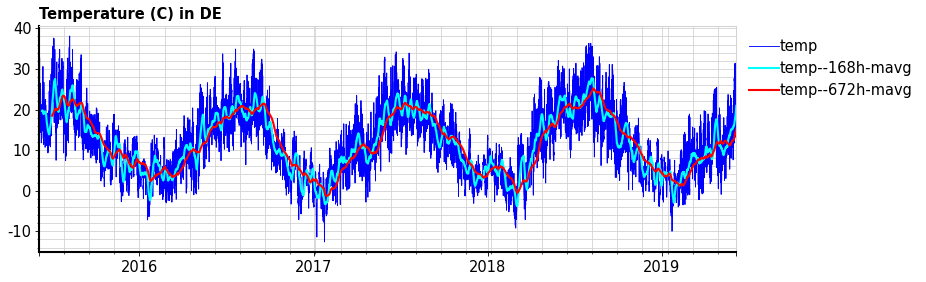

In [33]:
%%time
country = "DE"
roll_window = 24*7
df_weather_single_country = df_weather[df_weather["country"] == country]
ts_temp = df_weather_single_country.set_index("startdatehour")["temp"]
plot_dict = {"temp": [ts_temp.loc["2015-06-04":"2019-06-05"], "blue", "-", 0.85]}
plot_dict.update(
    {
        f"temp--{roll_window}h-mavg": [
            ts_temp.loc["2015-06-04":"2019-06-05"].rolling(roll_window).mean(), "cyan", "-", 2
        ]
    }
)
plot_dict.update(
    {
        f"temp--{24*7*4}h-mavg": [
            ts_temp.loc["2015-06-04":"2019-06-05"].rolling(24*7*4).mean(), "red", "-", 2
        ]
    }
)
vh.plot_multi_ts(
    plot_dict,
    f"Temperature (C) in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=14,
    dpi=75,
    fig_size=(12, 4),
)

**Observations**
1. Temperature has a predictably strong yearly seasonality, with no trend.

Check stationarity of the temperature timeseries in `DE` using the ADF test

In [34]:
%%time
check_stationarity(ts_temp, f"temp-{country}").style.apply(
    lambda x: ['background-color: yellow' if x.name in adf_rows else '' for i in x],
    axis=1
)

CPU times: user 28.3 s, sys: 44.3 s, total: 1min 12s
Wall time: 6.95 s


,Value,module
name,temp-DE,nan
ADF_Statistic,-7.810352,adfuller
p-value,0.000000,adfuller
num_lags_used,53,adfuller
n_observations_used,50346,adfuller
IC_for_best,124479.479287,adfuller
1%,-3.430480,adfuller
5%,-2.861597,adfuller
10%,-2.566801,adfuller
likely stationary,True,p-value < 0.05


**Observations**
1. As has been seen with electricity usage, the ADF test suggests that the temperature data is stationary. However, the clear yearly seasonality suggests otherwise. So, the temperature timeseries is not stationary.

Plot a histogram of the temperature timeseries data in `DE`

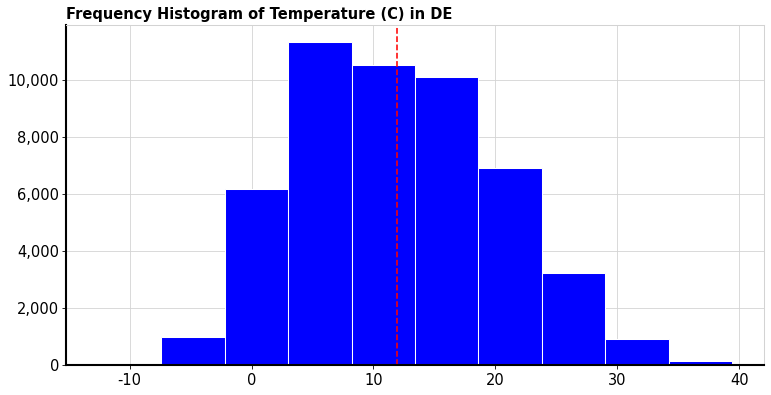

In [35]:
vh.plot_histogram(
    ts_temp,
    f"Frequency Histogram of Temperature (C) in {country}",
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    dpi=75,
    x_thou_comma_sep=True,
    y_thou_comma_sep=True,
    fig_size=(12, 6),
)

**Observations**
1. The distribution is slightly right skewed and looks like a broadened normal distribution. Earlier, we saw a bimodality in the distribution of electricity usage in `ES`. If that is also the case for temperatures in `DE`, then the modes would have to be centered around approx. +3C (average overnight temperatures) and +17C (daytime). These modes are'nt clearly visible.

Plot the auto-correlation of this temperature timeseries

CPU times: user 1.77 s, sys: 1.2 s, total: 2.98 s
Wall time: 267 ms


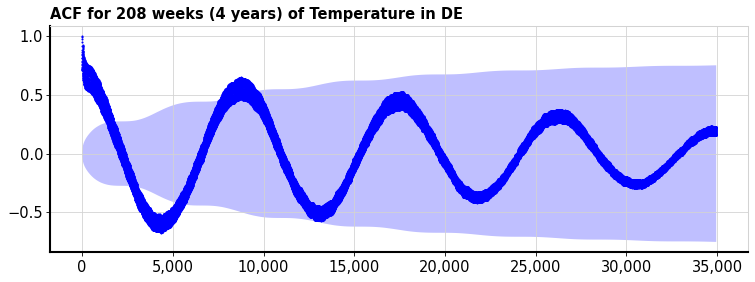

In [36]:
%%time
vh.plot_ts_acf(
    ts_temp,
    f"ACF for {52*4} weeks ({4} years) of Temperature in {country}",
    24 * 7 * 52 * 4,
    1,
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    dpi=75,
    fig_size=(12, 4),
)

**Observations**
1. Strong autocorrelation is observed in the temperature data.

Plot the wind speed timeseries for `DE`

CPU times: user 280 ms, sys: 1.29 ms, total: 282 ms
Wall time: 280 ms


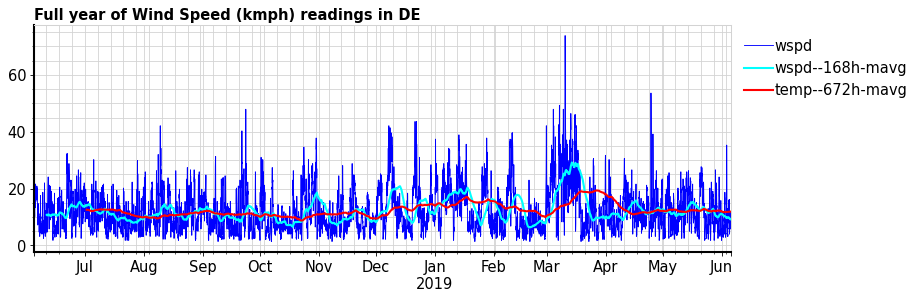

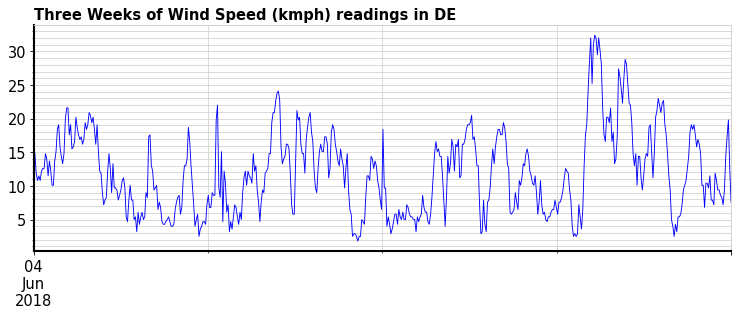

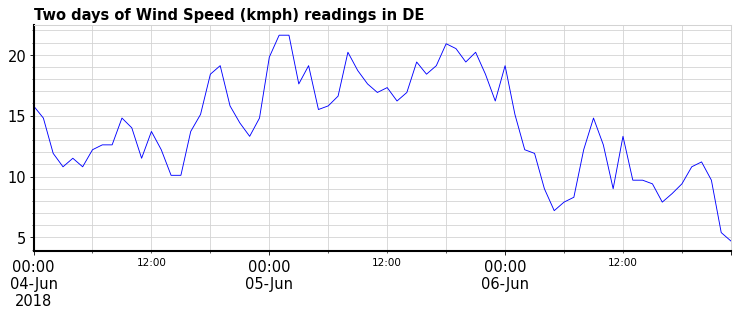

In [37]:
%%time
roll_window = 24*7
ts_wspd = df_weather_single_country.set_index("startdatehour")["wspd"]
plot_dict = {"wspd": [ts_wspd.loc["2018-06-04":"2019-06-05"], "blue", "-", 0.85]}
plot_dict.update(
    {
        f"wspd--{roll_window}h-mavg": [
            ts_wspd.loc["2018-06-04":"2019-06-05"].rolling(roll_window).mean(), "cyan", "-", 2
        ]
    }
)
plot_dict.update(
    {
        f"temp--{24*7*4}h-mavg": [
            ts_wspd.loc["2018-06-04":"2019-06-05"].rolling(24*7*4).mean(), "red", "-", 2
        ]
    }
)
vh.plot_multi_ts(
    plot_dict,
    f"Full year of Wind Speed (kmph) readings in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=14,
    dpi=75,
    fig_size=(12, 4),
)

plot_dict = {"wspd": [ts_wspd.loc["2018-06-04":"2018-06-25"], "blue", "-", 0.85]}
vh.plot_multi_ts(
    plot_dict,
    f"Three Weeks of Wind Speed (kmph) readings in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=14,
    dpi=75,
    fig_size=(12, 4),
)

plot_dict = {"wspd": [ts_wspd.loc["2018-06-04":"2018-06-06"], "blue", "-", 0.85]}
vh.plot_multi_ts(
    plot_dict,
    f"Two days of Wind Speed (kmph) readings in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=14,
    dpi=75,
    fig_size=(12, 4),
)

**Observations**
1. The strongest wind speeds occur during the winter months - Feb and Mar. Maximum intensity wind speed in the summer is weaker than that in the winter.

The seasonal decomposition (to separate the underlying seasonality and trend in wind speed readings) of this timeseries is shown below

CPU times: user 161 ms, sys: 1.54 ms, total: 162 ms
Wall time: 161 ms


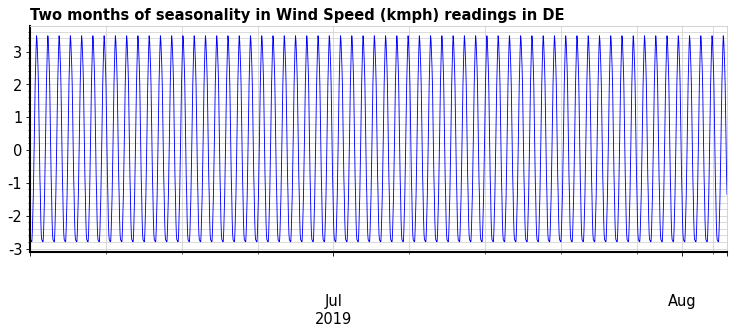

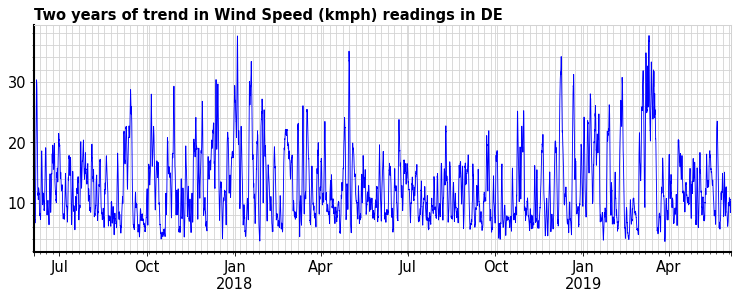

In [38]:
%%time
result = seasonal_decompose(ts_wspd, model="additive")
plot_dict = {"wspd": [result.seasonal.loc["2019-06-04":"2019-08-04"], "blue", "-", 0.85]}
vh.plot_multi_ts(
    plot_dict,
    f"Two months of seasonality in Wind Speed (kmph) readings in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=14,
    dpi=75,
    fig_size=(12, 4),
)
plot_dict = {"wspd": [result.trend.loc["2017-06-04":"2019-06-04"], "blue", "-", 0.85]}
vh.plot_multi_ts(
    plot_dict,
    f"Two years of trend in Wind Speed (kmph) readings in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=14,
    dpi=75,
    fig_size=(12, 4),
)

Check stationarity of the windspeed timeseries using the ADF test

In [39]:
%%time
check_stationarity(ts_wspd, f"wspd-{country}").style.apply(
    lambda x: ['background-color: yellow' if x.name in adf_rows else '' for i in x],
    axis=1
)

CPU times: user 24.7 s, sys: 35.8 s, total: 1min
Wall time: 5.28 s


,Value,module
name,wspd-DE,nan
ADF_Statistic,-21.700626,adfuller
p-value,0.000000,adfuller
num_lags_used,53,adfuller
n_observations_used,50346,adfuller
IC_for_best,247884.061026,adfuller
1%,-3.430480,adfuller
5%,-2.861597,adfuller
10%,-2.566801,adfuller
likely stationary,True,p-value < 0.05


**Observations**
1. As has been seen with electricity usage, the ADF test suggests that the wind speed data is stationary. However, the seasonal decomposition clearly shows a daily seasonality suggesting otherwise. So, the wind speed timeseries is not stationary.

Plot a histogram of the wind speed timeseries data in `DE`

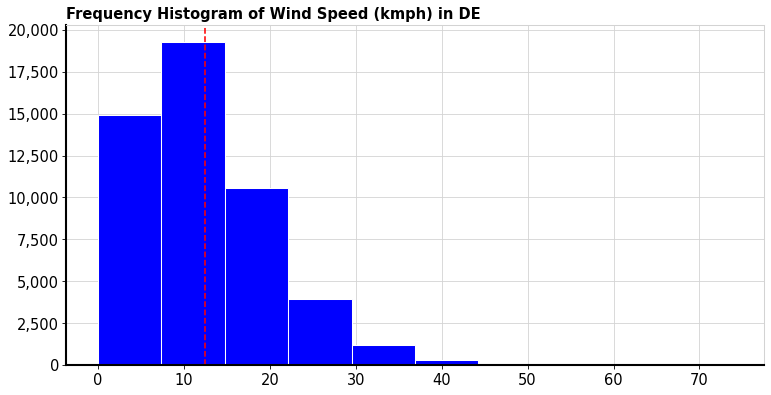

In [40]:
vh.plot_histogram(
    ts_wspd,
    f"Frequency Histogram of Wind Speed (kmph) in {country}",
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    dpi=75,
    x_thou_comma_sep=True,
    y_thou_comma_sep=True,
    fig_size=(12, 6),
)

**Observations**
1. The distribution of wind speed readings in `DE` has a right skew.

Plot the auto-correlation of the windspeed timeseries in `DE`

CPU times: user 1.66 s, sys: 941 ms, total: 2.6 s
Wall time: 240 ms


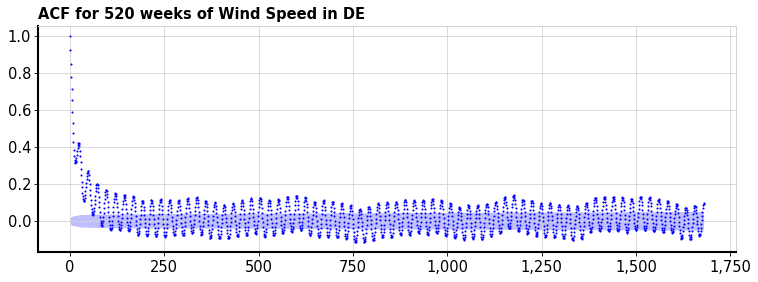

In [41]:
%%time
vh.plot_ts_acf(
    ts_wspd,
    f"ACF for {52*10} weeks of Wind Speed in {country}",
    24 * 7 * 10,
    1,
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    dpi=75,
    fig_size=(12, 4),
)

CPU times: user 1.43 s, sys: 1.27 s, total: 2.7 s
Wall time: 245 ms


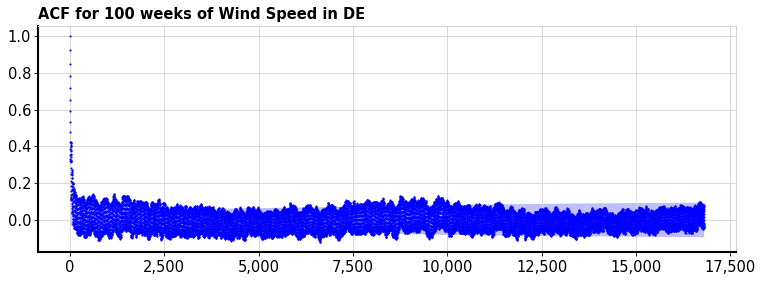

In [42]:
%%time
vh.plot_ts_acf(
    ts_wspd,
    f"ACF for 100 weeks of Wind Speed in {country}",
    24 * 7 * 100,
    1,
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    dpi=75,
    fig_size=(12, 4),
)

**Observations**
1. Autocorrelation beyond approx. (24 + 24 + 12) 60 hours is usually very small.

Plot the air pressure timeseries data for `DE`

CPU times: user 201 ms, sys: 1.47 ms, total: 202 ms
Wall time: 202 ms


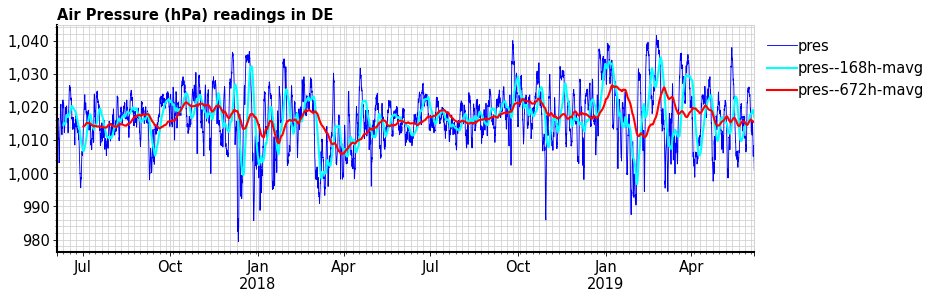

In [43]:
%%time
roll_window = 24*7
ts_pres = df_weather_single_country.set_index("startdatehour")["pres"]
plot_dict = {"pres": [ts_pres.loc["2017-06-04":"2019-06-05"], "blue", "-", 0.85]}
plot_dict.update(
    {
        f"pres--{roll_window}h-mavg": [
            ts_pres.loc["2017-06-04":"2019-06-05"].rolling(roll_window).mean(), "cyan", "-", 2
        ]
    }
)
plot_dict.update(
    {
        f"pres--{24*7*4}h-mavg": [
            ts_pres.loc["2017-06-04":"2019-06-05"].rolling(24*7*4).mean(), "red", "-", 2
        ]
    }
)
vh.plot_multi_ts(
    plot_dict,
    f"Air Pressure (hPa) readings in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=14,
    dpi=75,
    fig_size=(12, 4),
)

**Observations**
1. Similar to wind speed, the air pressure is strongest during the winter months and weakest during the summer. The variance in air pressure is also smaller during the warmer months than during the winter months.
2. There is no qualitative evidence of long-term trend in air pressure readings.

The seasonal decomposition of this timeseries is shown below

CPU times: user 153 ms, sys: 1.35 ms, total: 154 ms
Wall time: 154 ms


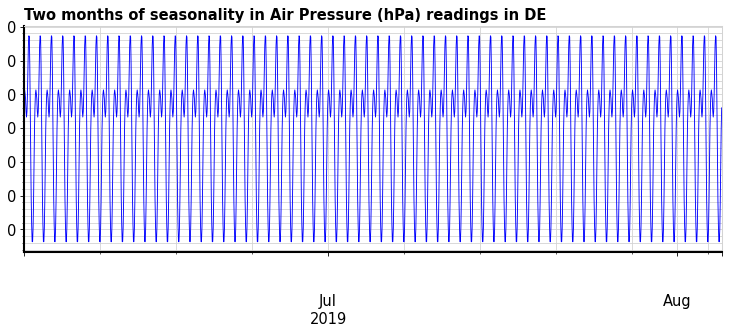

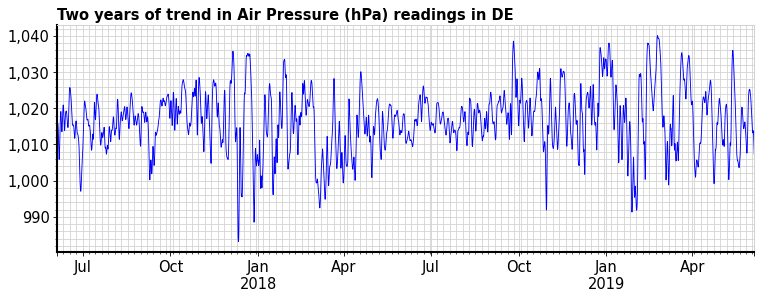

In [44]:
%%time
result = seasonal_decompose(ts_pres, model="additive")
plot_dict = {"pres": [result.seasonal.loc["2019-06-04":"2019-08-04"], "blue", "-", 0.85]}
vh.plot_multi_ts(
    plot_dict,
    f"Two months of seasonality in Air Pressure (hPa) readings in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=14,
    dpi=75,
    fig_size=(12, 4),
)
plot_dict = {"pres": [result.trend.loc["2017-06-04":"2019-06-04"], "blue", "-", 0.85]}
vh.plot_multi_ts(
    plot_dict,
    f"Two years of trend in Air Pressure (hPa) readings in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=14,
    dpi=75,
    fig_size=(12, 4),
)

Check stationarity of the air pressure timeseries using the ADF test

In [45]:
%%time
check_stationarity(ts_pres, f"pres-{country}").style.apply(
    lambda x: ['background-color: yellow' if x.name in adf_rows else '' for i in x],
    axis=1
)

CPU times: user 24.1 s, sys: 35.4 s, total: 59.5 s
Wall time: 5.13 s


,Value,module
name,pres-DE,nan
ADF_Statistic,-15.619530,adfuller
p-value,0.000000,adfuller
num_lags_used,57,adfuller
n_observations_used,50342,adfuller
IC_for_best,30239.541183,adfuller
1%,-3.430480,adfuller
5%,-2.861597,adfuller
10%,-2.566801,adfuller
likely stationary,True,p-value < 0.05


**Observations**
1. Again, the ADF test suggests that the air pressure data is stationary. However, the seasonal decomposition shows a daily seasonality indicating a lack of stationarity. So, the air pressure timeseries is not stationary.

Plot a histogram of the air pressure timeseries data in `DE`

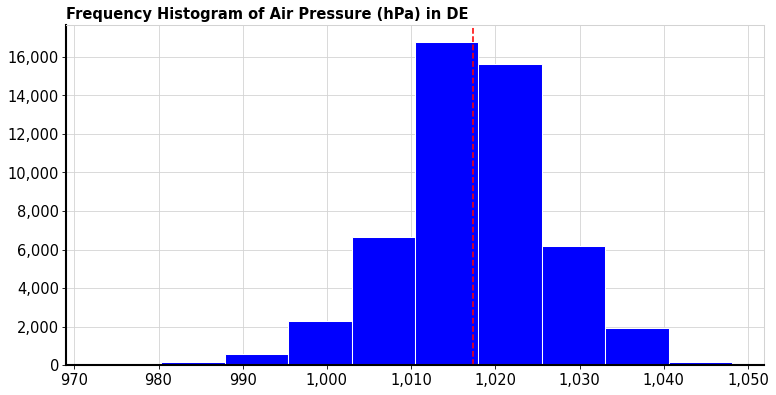

In [46]:
vh.plot_histogram(
    ts_pres,
    f"Frequency Histogram of Air Pressure (hPa) in {country}",
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    dpi=75,
    x_thou_comma_sep=True,
    y_thou_comma_sep=True,
    fig_size=(12, 6),
)

**Observations**
1. Air pressure is close to being normally distributed.

Plot the auto-correlation of the air pressure timeseries in `DE`

CPU times: user 1.57 s, sys: 1.91 s, total: 3.48 s
Wall time: 327 ms


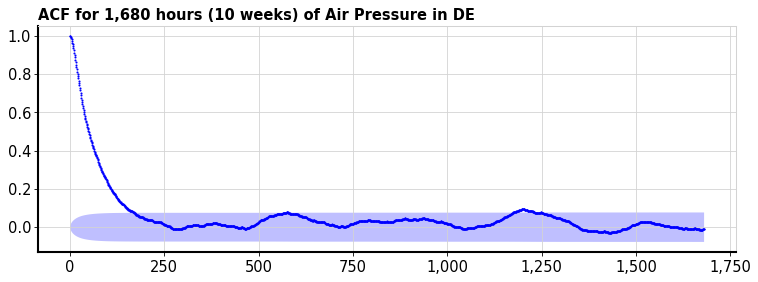

In [47]:
%%time
vh.plot_ts_acf(
    ts_pres,
    f"ACF for {24*7*10:,} hours ({10} weeks) of Air Pressure in {country}",
    24 * 7 * 10,
    1,
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    dpi=75,
    fig_size=(12, 4),
)

CPU times: user 1.92 s, sys: 2.86 s, total: 4.78 s
Wall time: 456 ms


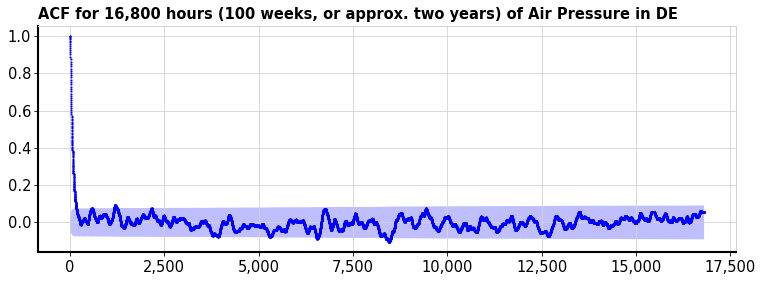

In [48]:
%%time
vh.plot_ts_acf(
    ts_pres,
    f"ACF for {24*7*100:,} hours ({100} weeks, or approx. two years) of Air Pressure in {country}",
    24 * 7 * 100,
    1,
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    dpi=75,
    fig_size=(12, 4),
)

**Observations**
1. As a rough estimate, autocorrelation beyond approx. 150 hours (approx. 6 days) is usually very small.

<a id="demographics-data-by-country"></a>

## 7. [Demographics Data by Country](#demographics-data-by-country)

We'll retrieve various indicators for each country using public data from [The World Bank](https://www.worldbank.org/en/home).

Load and combine demographics data for all countries and filter to get a subset of indicators from the combined demographics data

In [49]:
%%time
if use_demographics:
    executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
    tasks = (
        delayed(get_indicator_data)(c) for c in list(cntry_renaming_dict['country'])
    )
    dfs_indicators = executor(tasks)
    df_indicators = pd.concat(dfs_indicators, ignore_index=True)

    df_indicators = df_indicators[
        df_indicators["Indicator Name"].isin(indicators_wanted)
    ][
        ["Country Code", "Indicator Name"]
        + [str(y) for y in range(int(start_date), int(end_date) + 1)]
    ]
    show_df(df_indicators, 2)
    show_df_dtypes_nans(df_indicators)

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.58 µs


Reshape into tidy data format

In [50]:
if use_demographics:
    df_indicators = (
        df_indicators.set_index(["Country Code", "Indicator Name"])
        .stack()
        .reset_index()
        .rename(
            columns={
                "level_2": "year",
                0: "value",
                "Indicator Name": "indicator",
                "Country Code": "country",
            }
        )
        .replace(cntry_renaming_dict)
        .replace(
            {
                "indicator": {
                    ", total": "",
                    " applications": "_apps",
                    "listed domestic companies": "num_comps",
                    "labor force": "labor_force",
                }
            },
            regex=True,
        )
    )
    df_indicators["indicator"] = df_indicators["indicator"].str.lower()
    df_indicators["year"] = df_indicators["year"].astype(int)
    show_df(df_indicators, 2)
    show_df_dtypes_nans(df_indicators)

<a id="combine-data-sources"></a>

## 8. [Combine Data Sources](#combine-data-sources)

Combine the OPSD electricity usage and weather datasets, for the countries chosen for performing quantitative analysis

In [51]:
%%time
if use_demographics:
    df = df[df["country"].isin(list(station_lookup_ref_point_by_country))].merge(
        df_indicators,
        on=["country", "year"],
        how="left",
    )
df = df.merge(
    df_weather.rename(columns={"startdatehour": "utc_timestamp"}),
    on=["country", "utc_timestamp", "year"],
    how="left",
)
show_df(df, 2)
show_df_dtypes_nans(df)
df.info(memory_usage="deep")

,country,utc_timestamp,load,month,weekday,weekday_int,is_weekend,hour,year,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,from_station_name,timezone
0,BE,2015-01-01 00:00:00,9.484000,January,Thursday,3,False,0,2015,0.800000,-0.500000,91.000000,nan,nan,210.000000,10.800000,nan,1037.000000,nan,nan,Bruxelles National,Europe/Brussels
1,BE,2015-01-01 01:00:00,9.152000,January,Thursday,3,False,1,2015,0.500000,-0.800000,91.000000,nan,nan,210.000000,10.800000,nan,1036.700000,nan,nan,Bruxelles National,Europe/Brussels
503998,PL,2020-09-30 22:00:00,16.640110,September,Wednesday,2,False,22,2020,13.400000,12.500000,94.000000,0.000000,0.000000,40.000000,18.000000,27.800000,1010.100000,nan,7.000000,Warszawa-Okecie,Europe/Warsaw
503999,PL,2020-09-30 23:00:00,nan,September,Wednesday,2,False,23,2020,13.100000,12.300000,95.000000,0.000000,0.000000,30.000000,14.400000,29.600000,1009.700000,nan,7.000000,Warszawa-Okecie,Europe/Warsaw


,num_missing,dtypes
country,0,object
utc_timestamp,0,datetime64[ns]
load,182,float64
month,0,object
weekday,0,object
weekday_int,0,int64
is_weekend,0,bool
hour,0,int64
year,0,int64
temp,0,float64


<class 'pandas.core.frame.DataFrame'>
Int64Index: 504000 entries, 0 to 503999
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   country            504000 non-null  object        
 1   utc_timestamp      504000 non-null  datetime64[ns]
 2   load               503818 non-null  float64       
 3   month              504000 non-null  object        
 4   weekday            504000 non-null  object        
 5   weekday_int        504000 non-null  int64         
 6   is_weekend         504000 non-null  bool          
 7   hour               504000 non-null  int64         
 8   year               504000 non-null  int64         
 9   temp               504000 non-null  float64       
 10  dwpt               504000 non-null  float64       
 11  rhum               504000 non-null  float64       
 12  prcp               350060 non-null  float64       
 13  snow               140762 non-null  float64 

Examining the correlation between and [coefficient of variation (COV)](https://www.statology.org/coefficient-of-variation-in-python/) of the numerical (weather) features and the target (load)

In [52]:
%%time
NUMS = ["load", "temp", "rhum", "prcp", "wspd"]
df_univ_corr = (
    df.groupby("country")[NUMS].corr().add_suffix("_corr").reset_index().query("level_1 == 'load'").drop(
        columns=["level_1"]
    ).reset_index(drop=True)
)
df_cov = df.groupby("country").apply(
    calc_cov, list(set(NUMS) - set(["load"]))
).add_suffix("_cov").reset_index()
display(
    df_univ_corr.merge(df_cov, on="country").style.set_caption(
        "Correlation with Electricity Usage (higher is better) and "
        "Coefficient of Variation (lower is better), by country"
    )
)

,country,load_corr,temp_corr,rhum_corr,prcp_corr,wspd_corr,prcp_cov,temp_cov,wspd_cov,rhum_cov
0,BE,1.000000,-0.334319,0.102568,0.144420,0.100781,1.493445,0.605504,0.617711,0.211252
1,CH,1.000000,-0.415787,0.007978,0.019976,0.092158,3.577546,0.839842,0.787995,0.235599
2,CZ,1.000000,-0.403219,0.096613,-0.007462,0.141039,8.457254,0.844034,0.549926,0.244497
3,DE,1.000000,-0.144702,-0.015353,0.008066,0.160889,6.605404,0.681653,0.609924,0.280306
4,ES,1.000000,0.098514,-0.139504,0.058300,0.093397,3.399438,0.594566,0.731380,0.422917
5,FR,1.000000,-0.654439,0.325511,0.013481,0.131532,5.149066,0.576349,0.514869,0.250362
6,HR,1.000000,0.039899,-0.196806,-0.016524,0.097229,4.718779,0.746490,0.869008,0.254351
7,IT,1.000000,0.218339,-0.279418,-0.028718,0.197109,5.352112,0.430343,0.622788,0.229200
8,NL,1.000000,-0.131442,-0.008993,0.030452,0.156262,4.976218,0.566591,0.588694,0.184057
9,PL,1.000000,-0.165310,-0.024810,-0.030537,0.151364,4.683356,0.848882,0.547584,0.252577


CPU times: user 253 ms, sys: 14.6 ms, total: 268 ms
Wall time: 267 ms


**Observations**
1. Predictably, temperature has the strongest correlation to electricity usage, but this is not true in half of the countries (`DE`, `ES`, `HR`, `NL` and `PL`) being used here. Variations in incentivizations for managing electricity usage are possibly responsible for these differences by country.

<a id="feature-engineering"></a>

## 9. [Feature Engineering](#feature-engineering)

<a id="temperature"></a>

### 9.1. [Temperature](#temperature)

Show scatterplots of temperature against electricity usage for each country

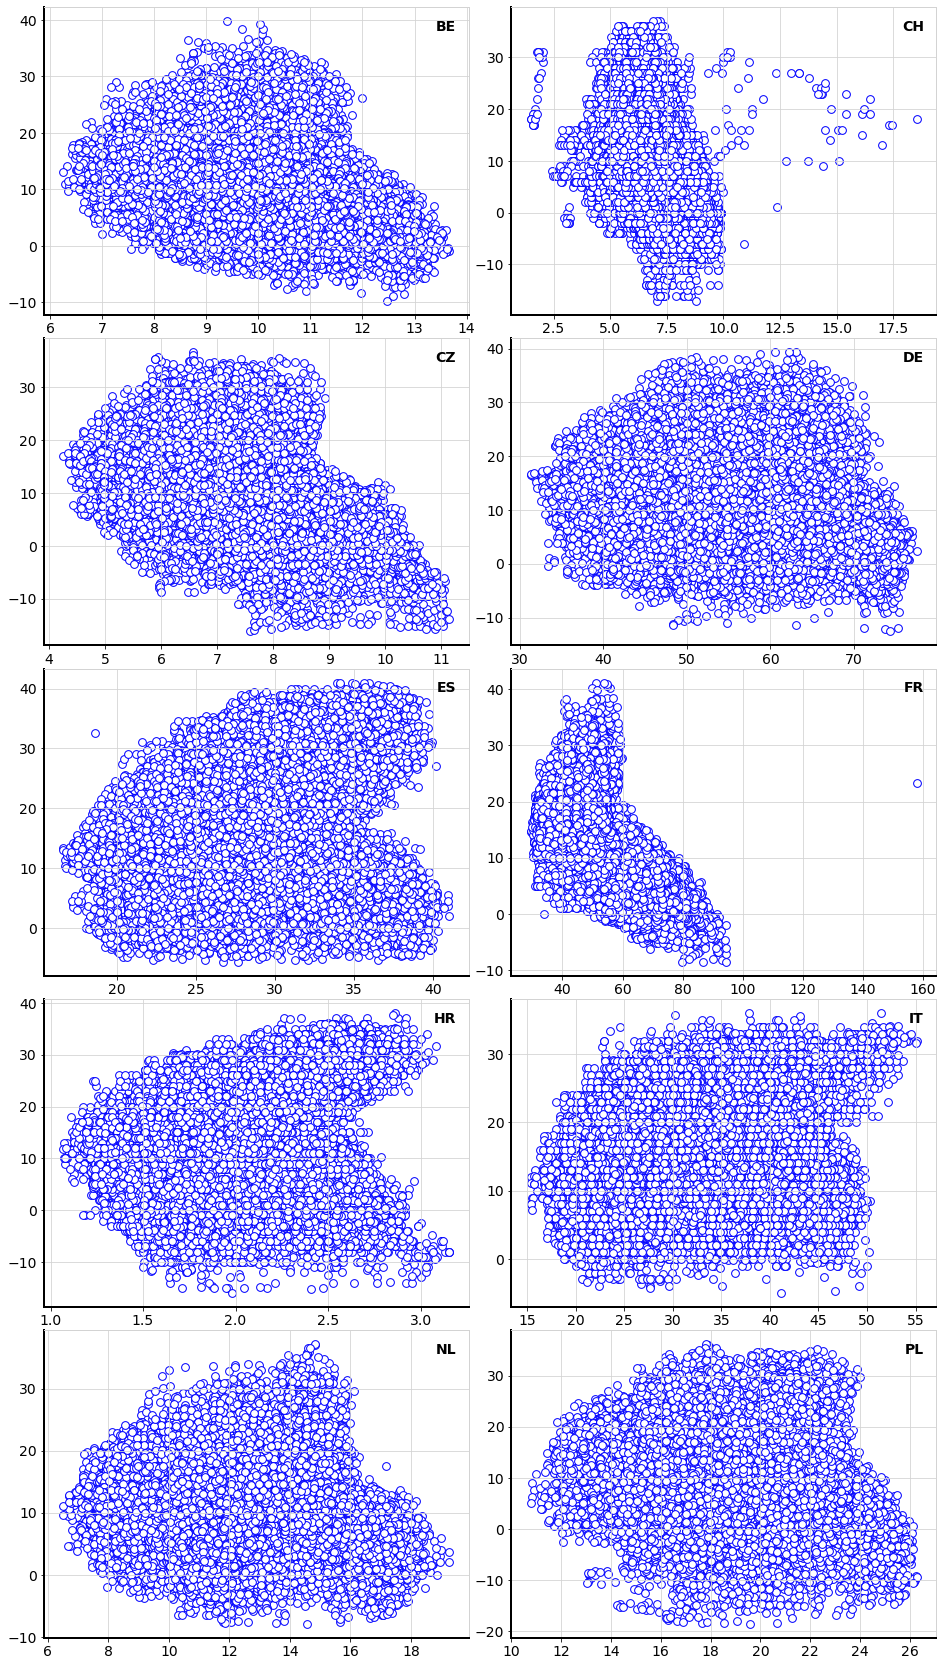

In [53]:
vh.plot_pairwise_scatterplot_grid(
    df,
    "country",
    "load",
    "temp",
    [["BE", "CH"], ["CZ", "DE"], ["ES", "FR"], ["HR", "IT"], ["NL", "PL"]],
    tick_label_fontsize=14,
    legend_fontsize=14,
    fig_size=(16, 30),
)

**Observations**
1. We see two clear modes (positive and negative sloping) here, though it's also apparent from the wide horizontal scatter that other effects are at play.

We'll try to add a *too hot* and *too cold* feature
- if the outdoor temperature is considered [comfortable](https://en.wikipedia.org/wiki/Room_temperature#Comfort_temperatures) about +20), then we'll assume that air-conditioners or heaters will not be used and electricity usage drops, and vice-versa. If it is too cold, then gas heating may be alternative that doesn't increase electricity usage more than if it is too hot (since air conditioners do not have any similar alternative). So, more electricity is used if it is too hot rather than too cold.

One approach to handle this is to create a boolean column that is sensitive to the absolute deviation from this comfort temperature
  - *too hot*
    - if the difference between the true and comfort temperatures is less than zero (comfort temp. is higher than outdoor temp.), then this indicates
      - it is *too hot* outside
      - the user needs to turn up their indoor heater to reach the a comfortable temperature indoors

      and we'll take the absolute value of this difference to be *too_hot*
    - if the comfort temp. is lower than the outdoor temp., then the user should turn off their indoor heater in order to reach the comfort temp. indoors
      - set the *too_hot* column to zero
  - *too cold*
    - if the difference is greater than zero (comfort temp. is less than outdoor temp.), then we'll take the absolute value of the difference in these two temperatures to be *too_cold*; if it is less than zero then set the *too_cold* column to zero

In [54]:
%%time
df = df.groupby("country").apply(get_too_hot_cold, threshold=comfort_threshold)
show_df(df)

,country,utc_timestamp,load,month,weekday,weekday_int,is_weekend,hour,year,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,from_station_name,timezone,too_hot,too_cold
0,BE,2015-01-01 00:00:00,9.484000,January,Thursday,3,False,0,2015,0.800000,-0.500000,91.000000,nan,nan,210.000000,10.800000,nan,1037.000000,nan,nan,Bruxelles National,Europe/Brussels,0.000000,19.200000
1,BE,2015-01-01 01:00:00,9.152000,January,Thursday,3,False,1,2015,0.500000,-0.800000,91.000000,nan,nan,210.000000,10.800000,nan,1036.700000,nan,nan,Bruxelles National,Europe/Brussels,0.000000,19.500000
2,BE,2015-01-01 02:00:00,8.799000,January,Thursday,3,False,2,2015,0.200000,-1.200000,90.000000,nan,nan,220.000000,10.800000,nan,1036.400000,nan,nan,Bruxelles National,Europe/Brussels,0.000000,19.800000
3,BE,2015-01-01 03:00:00,8.567000,January,Thursday,3,False,3,2015,-0.100000,-1.500000,90.000000,nan,nan,190.000000,10.800000,nan,1036.500000,nan,nan,Bruxelles National,Europe/Brussels,0.000000,20.100000
4,BE,2015-01-01 04:00:00,8.487000,January,Thursday,3,False,4,2015,-0.200000,-1.600000,90.000000,nan,nan,190.000000,10.800000,nan,1035.600000,nan,nan,Bruxelles National,Europe/Brussels,0.000000,20.200000
503995,PL,2020-09-30 19:00:00,20.788890,September,Wednesday,2,False,19,2020,13.800000,12.700000,93.000000,1.200000,0.000000,40.000000,18.000000,29.600000,1010.400000,nan,7.000000,Warszawa-Okecie,Europe/Warsaw,0.000000,6.200000
503996,PL,2020-09-30 20:00:00,19.040560,September,Wednesday,2,False,20,2020,13.500000,12.700000,95.000000,0.200000,0.000000,30.000000,14.400000,27.800000,1010.400000,nan,7.000000,Warszawa-Okecie,Europe/Warsaw,0.000000,6.500000
503997,PL,2020-09-30 21:00:00,17.697310,September,Wednesday,2,False,21,2020,13.500000,12.600000,94.000000,0.300000,0.000000,40.000000,18.000000,27.800000,1010.300000,nan,7.000000,Warszawa-Okecie,Europe/Warsaw,0.000000,6.500000
503998,PL,2020-09-30 22:00:00,16.640110,September,Wednesday,2,False,22,2020,13.400000,12.500000,94.000000,0.000000,0.000000,40.000000,18.000000,27.800000,1010.100000,nan,7.000000,Warszawa-Okecie,Europe/Warsaw,0.000000,6.600000
503999,PL,2020-09-30 23:00:00,nan,September,Wednesday,2,False,23,2020,13.100000,12.300000,95.000000,0.000000,0.000000,30.000000,14.400000,29.600000,1009.700000,nan,7.000000,Warszawa-Okecie,Europe/Warsaw,0.000000,6.900000


CPU times: user 421 ms, sys: 42.2 ms, total: 463 ms
Wall time: 463 ms


Checking the correlation and COV again

In [55]:
%%time
NUMS = ["load", "temp", "rhum", "prcp", "wspd", "too_hot", "too_cold"]
df_univ_corr = (
    df.groupby("country")[NUMS].corr().add_suffix("_corr").reset_index().query("level_1 == 'load'").drop(
        columns=["level_1"]
    ).reset_index(drop=True)
)
df_cov = df.groupby("country").apply(
    calc_cov, list(set(NUMS) - set(["load"]))
).add_suffix("_cov").reset_index()
display(
    df_univ_corr.merge(df_cov, on="country").style.set_caption(
        "Correlation with Electricity Usage (higher is better) and "
        "Coefficient of Variation (lower is better), by country"
    )
)

,country,load_corr,temp_corr,rhum_corr,prcp_corr,wspd_corr,too_hot_corr,too_cold_corr,too_hot_cov,temp_cov,too_cold_cov,rhum_cov,prcp_cov,wspd_cov
0,BE,1.000000,-0.334319,0.102568,0.144420,0.100781,-0.034290,0.365848,3.749029,0.605504,0.687908,0.211252,1.493445,0.617711
1,CH,1.000000,-0.415787,0.007978,0.019976,0.092158,-0.112091,0.443553,3.209366,0.839842,0.728775,0.235599,3.577546,0.787995
2,CZ,1.000000,-0.403219,0.096613,-0.007462,0.141039,-0.080112,0.432665,3.318441,0.844034,0.725492,0.244497,8.457254,0.549926
3,DE,1.000000,-0.144702,-0.015353,0.008066,0.160889,-0.001045,0.170667,2.889025,0.681653,0.778476,0.280306,6.605404,0.609924
4,ES,1.000000,0.098514,-0.139504,0.058300,0.093397,0.209416,-0.005307,1.908461,0.594566,0.986058,0.422917,3.399438,0.731380
5,FR,1.000000,-0.654439,0.325511,0.013481,0.131532,-0.181975,0.713857,3.018988,0.576349,0.769958,0.250362,5.149066,0.514869
6,HR,1.000000,0.039899,-0.196806,-0.016524,0.097229,0.288732,0.051886,2.432770,0.746490,0.889948,0.254351,4.718779,0.869008
7,IT,1.000000,0.218339,-0.279418,-0.028718,0.197109,0.278348,-0.145302,1.805344,0.430343,1.058528,0.229200,5.352112,0.622788
8,NL,1.000000,-0.131442,-0.008993,0.030452,0.156262,0.044974,0.153487,4.283144,0.566591,0.674681,0.184057,4.976218,0.588694
9,PL,1.000000,-0.165310,-0.024810,-0.030537,0.151364,0.049846,0.197401,3.013669,0.848882,0.775467,0.252577,4.683356,0.547584


CPU times: user 193 ms, sys: 0 ns, total: 193 ms
Wall time: 192 ms


**Observations**
1. With the exception of `ES` and `HR`, this has weakly improved correlation between the now newly engineered features and the electricity usage. With the exception of those two countries, there is still enough of a spread in values, within the separate modes, that they remain weakly correlated to to the electricity usage. It is apparent from this wide vertical scatter that other effects are at play.
2. The COV is approximately five times worse (higher) for the engineered `too_hot` feature than for the raw temperature.

With these observations in mind, we'll exclude use of the engineered features in analysis here. They could be optimized and tried in future vresions of this project.

<a id="covid-19-shock"></a>

### 9.2. [COVID-19 shock](#covid-19-shock)

Next, we'll plot electricity consumption during the first nine months of the year in 2019 and 2020 in order to visualize the impact of the COVID-19 shock which will be included in the training dataset

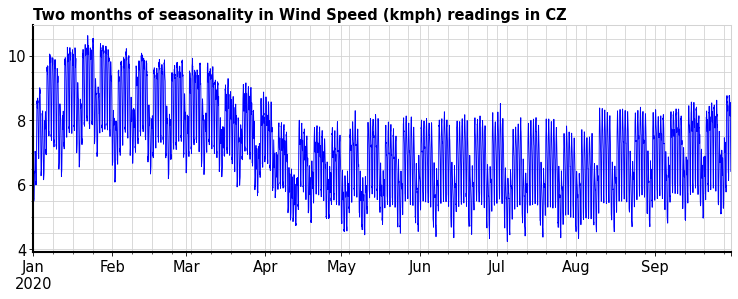

In [56]:
country = "CZ"
plot_dict = {
    "2020": [
        df[df["country"] == country].set_index("utc_timestamp")["load"].loc["2020"],
        "blue",
        "-",
        0.85,
    ],
}
vh.plot_multi_ts(
    plot_dict,
    f"Two months of seasonality in Wind Speed (kmph) readings in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=14,
    dpi=75,
    fig_size=(12, 4),
)

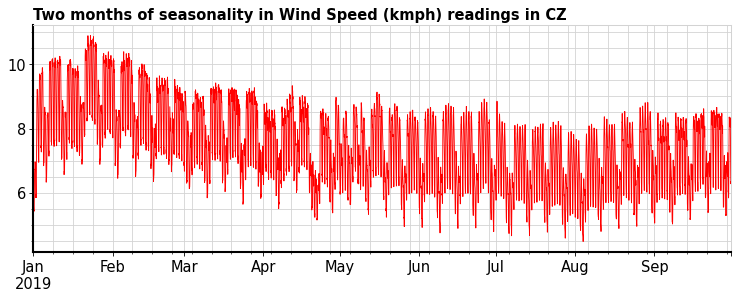

In [57]:
plot_dict = {
    "2019": [
        df[df["country"] == country]
        .set_index("utc_timestamp")["load"]
        .loc["2019-01-01":"2019-09-30 23:00:00"],
        "red",
        "-",
        0.85,
    ],
}
vh.plot_multi_ts(
    plot_dict,
    f"Two months of seasonality in Wind Speed (kmph) readings in {country}",
    zero_line_color="",
    legend_loc=(1, 1),
    tick_label_fontsize=14,
    ptitle_fontsize=14,
    legend_fontsize=14,
    dpi=75,
    fig_size=(12, 4),
)

Based on the above plots, we'll approximate the following range of dates as corresponding to COVID-19 shutdowns during 2020, where we've assumed shutdowns were eased starting on [Easter Sunday 2020](http://www.apples4theteacher.com/holidays/easter-religious/when-is-easter.html). This will have the following categories
- *no-corona*
  - this will imply that year-over-year consumption of electricity during the following two periods are equivalent
    - post-onset of pandemic (i.e. after Easter Sunday 2020)
      - loosening of restrictions that existed after the strict shutdown that occurred at the immediate onset of the pandemic in March 2020
    - pre-pandemic (before the first or second week of March 2020, depending on the country)
- *pre-corona*
  - period before the onset of the pandemic (before the first or second week of March 2020)
- *post-corona*
  - loosening of restrictions (i.e. after Easter Sunday 2020)
- *during-corona*
  - this corresponds to the above-mentioned range of dates corresponding to the strict shutdowns during the period from mid-March to Easter Sunday in 2020

A helper function `add_corona_dates()` will be used and will generate all three categories. However, during quantitative analysis, we'll have to choose whether the use one of the following two pairs of categories
- *no-corona* and *during-corona*
- *pre-corona*, *during-corona* and *post-corona*

In [58]:
%%time
df = add_corona_dates(df, "utc_timestamp")
show_df(df, 2)
show_df_dtypes_nans(df)

,country,utc_timestamp,load,month,weekday,weekday_int,is_weekend,hour,year,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,from_station_name,timezone,too_hot,too_cold,corona_start,corona_end,no_corona,during_corona
0,BE,2015-01-01 00:00:00,9.484000,January,Thursday,3,False,0,2015,0.800000,-0.500000,91.000000,nan,nan,210.000000,10.800000,nan,1037.000000,nan,nan,Bruxelles National,Europe/Brussels,0.000000,19.200000,2020-03-07 00:00:00,2020-04-12 23:00:00,True,False
1,BE,2015-01-01 01:00:00,9.152000,January,Thursday,3,False,1,2015,0.500000,-0.800000,91.000000,nan,nan,210.000000,10.800000,nan,1036.700000,nan,nan,Bruxelles National,Europe/Brussels,0.000000,19.500000,2020-03-07 00:00:00,2020-04-12 23:00:00,True,False
503998,PL,2020-09-30 22:00:00,16.640110,September,Wednesday,2,False,22,2020,13.400000,12.500000,94.000000,0.000000,0.000000,40.000000,18.000000,27.800000,1010.100000,nan,7.000000,Warszawa-Okecie,Europe/Warsaw,0.000000,6.600000,2020-03-14 00:00:00,2020-04-12 23:00:00,True,False
503999,PL,2020-09-30 23:00:00,nan,September,Wednesday,2,False,23,2020,13.100000,12.300000,95.000000,0.000000,0.000000,30.000000,14.400000,29.600000,1009.700000,nan,7.000000,Warszawa-Okecie,Europe/Warsaw,0.000000,6.900000,2020-03-14 00:00:00,2020-04-12 23:00:00,True,False


,num_missing,dtypes
country,0,object
utc_timestamp,0,datetime64[ns]
load,182,float64
month,0,object
weekday,0,object
weekday_int,0,int64
is_weekend,0,bool
hour,0,int64
year,0,int64
temp,0,float64


CPU times: user 289 ms, sys: 1.73 ms, total: 290 ms
Wall time: 289 ms


Verify that a *during-corona* period exists in this (training) data (which includes dates during March-September 2020)

In [59]:
assert not df[df["during_corona"]].empty

<a id="export-training-(merged)-and-testing-data"></a>

## 10. [Export training (merged) and testing data](#export-training-(merged)-and-testing-data)

In [60]:
show_df_dtypes_nans(df)
# show_df_dtypes_nans(df_test)

,num_missing,dtypes
country,0,object
utc_timestamp,0,datetime64[ns]
load,182,float64
month,0,object
weekday,0,object
weekday_int,0,int64
is_weekend,0,bool
hour,0,int64
year,0,int64
temp,0,float64


We'll save the electricity load data for the training split (used during model development) and the inputs for the data to be used for inference to a parquet file

In [ ]:
timestr = time.strftime("%Y%m%d_%H%M%S")
parquet_filepath = os.path.join(
    processed_data_dir,
    "train_" + timestr + ".parquet",
)
try:
    print(f"Saving data to {parquet_filepath + '.gzip'}", end="...")
    df.to_parquet(
        parquet_filepath + ".gzip",
        engine="auto",
        index=False,
        compression="gzip",
    )
    print("done.")
except Exception as e:
    print(str(e))

<a id="links"></a>

## 11. [Links](#links)

1. WorldBank Data for
   - [DE](https://data.worldbank.org/country/germany?view=chart)
   - [CZ](https://data.worldbank.org/country/czech-republic?view=chart)
   - [SUI](https://data.worldbank.org/country/switzerland?view=chart)
   - [NL](https://data.worldbank.org/country/netherlands?view=chart)
   - [ES](https://data.worldbank.org/country/spain?view=chart)
   - [IT](https://data.worldbank.org/country/italy?view=chart)
   - [HR](https://data.worldbank.org/country/croatia?view=chart)
   - [BE](https://data.worldbank.org/country/belgium?view=chart)
   - [FR](https://data.worldbank.org/country/france?view=chart)
   - [PL](https://data.worldbank.org/country/poland?view=chart)
2. ENTSO-E electricity load consumption by country from OPSD data portal
   - see the `time_series_60min_singleindex.csv` file from [here](https://data.open-power-system-data.org/time_series/latest)
3. Weather data from [Meteostat](https://meteostat.net/en)'s [Python package](https://pypi.org/project/meteostat/).

---

<span style="float:left">
    2020 | <a href="https://github.com/edesz/store-item-forecast">@edesz</a> (MIT)
</span>

<span style="float:right">
    <a href="./1_naive.ipynb">1 - Develop and Evaluate Naive Forecasts >>></a>
</span>